In [95]:
def ns_sim(p, alpha, rs, b_0, e_in_en, g_in, r_in, theta_in, en_loss, xi_obs=None, att='False'):
    # We import our libraries
    import numpy as np
    import scipy.special as sp
    from scipy.integrate import quad
    # We define our constants
    e = 1.6e-19  # C
    me = 9.1e-31  # kg
    mu = 4*np.pi*1e-7  # H/m
    c = 299792458  # m/s
    h = 4.135667696*1e-15  # eV/s
    hbar = h/(2*np.pi)

    if en_loss >= 0:
        return print('Energy loss rate must be negative')
    # We calculate geometry parameters
    rlc = c*p/(2*np.pi)  # Radio of the light cylinder
    theta_pc = np.arcsin(np.sqrt(rs/rlc))  # Polar cap angle
    rpc = theta_pc*rs  # Polar cap radius
    def curv_r(r, theta):  # Curvature radius function
        k = r/(np.sin(theta))**2
        return k*((np.sin(theta))**4+(np.sin(2*theta))**2)/((np.sin(theta))**4+2*(np.sin(2*theta))**2-2*(np.sin(theta))**2*np.cos(2*theta))

    def curv_tan(theta):  # Local tangent function
        return (3*(np.cos(theta))**2-1)/(3*np.sin(theta)*np.cos(theta))

    # Electron acceleration
    def E_par(height):
        return 1e9*np.exp(-height/rpc)

    # Curvature radiation maximum
    def Ecr(gamma, r, theta):
        return 3/2*c*hbar*gamma**3/curv_r(r, theta)

    def Fsyn(x):
        return x * quad(lambda y: sp.kv(5 / 3, y), x, np.inf)[0]

    # Curvature radiation
    def dNdE(E, gamma, r, theta):
        return (np.sqrt(3)*e**2*gamma)/(h*E*curv_r(r, theta))*Fsyn(E/Ecr(gamma, r, theta))

    # Energy loss rate
    def gdot(gamma, r, theta):
        return -2/3*e**2/(me*c)*(gamma**4)/((curv_r(r, theta))**2)

    # Absorption via magnetic field
    def B(m, r, theta):  # theta must be in rad
        return mu*m/(4*np.pi*r**3)*np.sqrt(1+3*(np.sin(np.pi-theta))**2)
    mag = b_0 * rs**3 * 4*np.pi/(mu * np.sqrt(1+3*(np.sin(np.pi-theta_in))**2))  # we calculate the intensity of
    # magnetic dipole given B on the NS surface
    bcrit = 4.4 * 10**13  # in gauss

    def e_esc(r, theta):
        return (0.1 * bcrit * 0.01) / (theta * b_0) * (r / rs)**(5/2)
    # The algorithm: given initial E and position (r, theta)
    en = np.copy(e_in_en)
    e_r = np.copy(r_in)
    e_theta = np.copy(theta_pc)
    k = e_r/(np.sin(e_theta))**2

    if en == None:
        g = g_in
        if g == None:
            return print('No initial electron energy or Lorentz factor given')
    else:
        g = en/0.510998950  # electron energy must be in MeV
        g_in = np.copy(g)
    f_en = np.logspace(-3, 4, 1000)  # we initialize photon energies
    sn = np.zeros(len(f_en))  # 0's list in which we store the summed photon spectrum
    hist = np.histogram(f_en, bins=f_en)  # we bin the data
    bins = hist[1]
    binned_en = []
    photon_number = []
    phi=[]
    xi=[]
    beta = np.linspace(0, 2*np.pi, 10000)
    for n in range(len(bins) - 1):  # this can be done just once since f_en is the same in each step
        binned_en.append((bins[n] + bins[n + 1]) / 2)
    sc = np.zeros(len(binned_en))  # 0's list in which store counts for binned spectrum
    while e_r < rlc:  # we track the electron until it reaches the light cylinder
        vn = []  # empty list in which we store spectrum in each step
        for n in f_en:  # we calculate photon spectrum
            vn.append(dNdE(n*10**9, g, e_r, e_theta)*10**9)  # This gives dNdE in eV^-1, so we multiply by 10^9 to
            # get GeV^-1)
        # vn = vn / vn[-1]  # we normalize the counts
        hist = np.histogram(f_en, bins=f_en, weights=vn)  # we bin the data
        counts = hist[0]
        v = np.copy(counts)
        esc = e_esc(e_r, e_theta)
        print('Escape energy in this step:', '{:.2f}'.format(esc))
        # we calculate attenuation for each spectrum
        for n in range(len(binned_en)-1):
            long_bin = (binned_en[n+1] - binned_en[n]) / 2 #semi-size of each bin
            if binned_en[n]-long_bin < esc < binned_en[n]+long_bin:
                p_abs = esc/(binned_en[n]+long_bin)  # probability to be absorbed
                counts[n] = counts[n]*(1-p_abs)  # number of photons after the absorption
                for d in range(n+1, len(binned_en)):
                    counts[d] = 0
        sc += counts
        sn += vn
        z = np.copy(counts)
        if att == 'True':
            for n in range(len(binned_en)):
                v[n] = v[n] * binned_en[n] ** 2
                z[n] = z[n]*binned_en[n]**2
            plt.plot(binned_en, v, label='No absorption')
            plt.plot(binned_en, z, '-.', label='With absorption')
            plt.grid(True)
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Photon energy E [GeV]')
            plt.ylabel(r'$E^2 dN/dE [MeV s^{-1}]$')
            plt.legend()
            plt.show()
        if xi_obs == None:
            for n in range(len(beta)):
                photon_number.append(np.sum(counts))  # this number of photons is emitted in the following direction
                xi.append(np.arccos((np.cos(alpha)*np.cos(e_theta)+np.sin(alpha)*np.cos(e_theta)*np.cos(np.pi-beta[n]))))
                phi.append(np.arccos((np.cos(e_theta)-np.cos(alpha)*np.cos(xi[n]))/(np.sin(alpha)*np.sin(xi[n]))))
        if xi_obs != None:
            phi.append(np.arccos((np.cos(e_theta)-np.cos(alpha)*np.cos(xi_obs))/(np.sin(alpha)*np.sin(xi_obs))))
            photon_number.append(sum(counts))

        ds = en_loss * c * g / gdot(g, e_r, e_theta)  # step for fixed energy loos rate
        if ds > 0.001*rs:
            ds = 0.001*rs
        dr = ds * (1+(np.tan(e_theta))**2/4)**(-1/2)  # step for radius
        e_r += dr  # we update the parameters to the next step
        e_theta = np.arcsin(np.sqrt(e_r/k))
        g += ds*gdot(g, e_r, e_theta)/c
        print('Progress:', '{:.2f}'.format(e_r/rlc*100), '%')
    return sn, f_en, sc, binned_en, photon_number, phi, xi

import numpy as np
import matplotlib.pyplot as plt

summed, photon_en, sc, binned_en, photon_number, phi, xi = ns_sim(p=2.3*10**(-3), xi_obs=65*np.pi/180, alpha=60*np.pi/180, rs=10e3, b_0=10**9, e_in_en=None, g_in=2e7, r_in=10e3, theta_in=15*np.pi/180, en_loss=-0.01)

Escape energy in this step: 143.49
Progress: 9.12 %
Escape energy in this step: 143.77
Progress: 9.13 %
Escape energy in this step: 144.05
Progress: 9.14 %
Escape energy in this step: 144.33
Progress: 9.15 %
Escape energy in this step: 144.61
Progress: 9.16 %
Escape energy in this step: 144.89
Progress: 9.17 %
Escape energy in this step: 145.18
Progress: 9.18 %
Escape energy in this step: 145.46
Progress: 9.18 %
Escape energy in this step: 145.74
Progress: 9.19 %
Escape energy in this step: 146.03
Progress: 9.20 %
Escape energy in this step: 146.31
Progress: 9.21 %
Escape energy in this step: 146.59
Progress: 9.22 %
Escape energy in this step: 146.88
Progress: 9.23 %
Escape energy in this step: 147.16
Progress: 9.24 %
Escape energy in this step: 147.45
Progress: 9.25 %
Escape energy in this step: 147.73
Progress: 9.26 %
Escape energy in this step: 148.02
Progress: 9.27 %
Escape energy in this step: 148.30
Progress: 9.27 %
Escape energy in this step: 148.59
Progress: 9.28 %
Escape energ

Escape energy in this step: 190.90
Progress: 10.53 %
Escape energy in this step: 191.22
Progress: 10.54 %
Escape energy in this step: 191.54
Progress: 10.55 %
Escape energy in this step: 191.87
Progress: 10.56 %
Escape energy in this step: 192.19
Progress: 10.57 %
Escape energy in this step: 192.51
Progress: 10.58 %
Escape energy in this step: 192.84
Progress: 10.59 %
Escape energy in this step: 193.16
Progress: 10.60 %
Escape energy in this step: 193.49
Progress: 10.60 %
Escape energy in this step: 193.81
Progress: 10.61 %
Escape energy in this step: 194.14
Progress: 10.62 %
Escape energy in this step: 194.46
Progress: 10.63 %
Escape energy in this step: 194.79
Progress: 10.64 %
Escape energy in this step: 195.12
Progress: 10.65 %
Escape energy in this step: 195.44
Progress: 10.66 %
Escape energy in this step: 195.77
Progress: 10.67 %
Escape energy in this step: 196.10
Progress: 10.68 %
Escape energy in this step: 196.42
Progress: 10.69 %
Escape energy in this step: 196.75
Progress: 1

Escape energy in this step: 244.06
Progress: 11.92 %
Escape energy in this step: 244.43
Progress: 11.93 %
Escape energy in this step: 244.79
Progress: 11.94 %
Escape energy in this step: 245.15
Progress: 11.95 %
Escape energy in this step: 245.52
Progress: 11.96 %
Escape energy in this step: 245.88
Progress: 11.97 %
Escape energy in this step: 246.25
Progress: 11.98 %
Escape energy in this step: 246.61
Progress: 11.99 %
Escape energy in this step: 246.98
Progress: 12.00 %
Escape energy in this step: 247.34
Progress: 12.00 %
Escape energy in this step: 247.71
Progress: 12.01 %
Escape energy in this step: 248.07
Progress: 12.02 %
Escape energy in this step: 248.44
Progress: 12.03 %
Escape energy in this step: 248.81
Progress: 12.04 %
Escape energy in this step: 249.17
Progress: 12.05 %
Escape energy in this step: 249.54
Progress: 12.06 %
Escape energy in this step: 249.91
Progress: 12.07 %
Escape energy in this step: 250.27
Progress: 12.08 %
Escape energy in this step: 250.64
Progress: 1

Escape energy in this step: 303.45
Progress: 13.31 %
Escape energy in this step: 303.85
Progress: 13.32 %
Escape energy in this step: 304.25
Progress: 13.33 %
Escape energy in this step: 304.66
Progress: 13.34 %
Escape energy in this step: 305.06
Progress: 13.35 %
Escape energy in this step: 305.47
Progress: 13.36 %
Escape energy in this step: 305.87
Progress: 13.36 %
Escape energy in this step: 306.28
Progress: 13.37 %
Escape energy in this step: 306.68
Progress: 13.38 %
Escape energy in this step: 307.09
Progress: 13.39 %
Escape energy in this step: 307.49
Progress: 13.40 %
Escape energy in this step: 307.90
Progress: 13.41 %
Escape energy in this step: 308.30
Progress: 13.42 %
Escape energy in this step: 308.71
Progress: 13.43 %
Escape energy in this step: 309.11
Progress: 13.44 %
Escape energy in this step: 309.52
Progress: 13.45 %
Escape energy in this step: 309.93
Progress: 13.45 %
Escape energy in this step: 310.34
Progress: 13.46 %
Escape energy in this step: 310.74
Progress: 1

Escape energy in this step: 368.95
Progress: 14.70 %
Escape energy in this step: 369.39
Progress: 14.70 %
Escape energy in this step: 369.84
Progress: 14.71 %
Escape energy in this step: 370.28
Progress: 14.72 %
Escape energy in this step: 370.72
Progress: 14.73 %
Escape energy in this step: 371.17
Progress: 14.74 %
Escape energy in this step: 371.61
Progress: 14.75 %
Escape energy in this step: 372.05
Progress: 14.76 %
Escape energy in this step: 372.50
Progress: 14.77 %
Escape energy in this step: 372.94
Progress: 14.78 %
Escape energy in this step: 373.39
Progress: 14.78 %
Escape energy in this step: 373.83
Progress: 14.79 %
Escape energy in this step: 374.28
Progress: 14.80 %
Escape energy in this step: 374.72
Progress: 14.81 %
Escape energy in this step: 375.17
Progress: 14.82 %
Escape energy in this step: 375.61
Progress: 14.83 %
Escape energy in this step: 376.06
Progress: 14.84 %
Escape energy in this step: 376.50
Progress: 14.85 %
Escape energy in this step: 376.95
Progress: 1

Escape energy in this step: 440.47
Progress: 16.08 %
Escape energy in this step: 440.96
Progress: 16.09 %
Escape energy in this step: 441.44
Progress: 16.09 %
Escape energy in this step: 441.92
Progress: 16.10 %
Escape energy in this step: 442.40
Progress: 16.11 %
Escape energy in this step: 442.88
Progress: 16.12 %
Escape energy in this step: 443.36
Progress: 16.13 %
Escape energy in this step: 443.85
Progress: 16.14 %
Escape energy in this step: 444.33
Progress: 16.15 %
Escape energy in this step: 444.81
Progress: 16.16 %
Escape energy in this step: 445.29
Progress: 16.17 %
Escape energy in this step: 445.78
Progress: 16.17 %
Escape energy in this step: 446.26
Progress: 16.18 %
Escape energy in this step: 446.74
Progress: 16.19 %
Escape energy in this step: 447.23
Progress: 16.20 %
Escape energy in this step: 447.71
Progress: 16.21 %
Escape energy in this step: 448.20
Progress: 16.22 %
Escape energy in this step: 448.68
Progress: 16.23 %
Escape energy in this step: 449.17
Progress: 1

Escape energy in this step: 517.91
Progress: 17.46 %
Escape energy in this step: 518.43
Progress: 17.46 %
Escape energy in this step: 518.95
Progress: 17.47 %
Escape energy in this step: 519.47
Progress: 17.48 %
Escape energy in this step: 519.99
Progress: 17.49 %
Escape energy in this step: 520.51
Progress: 17.50 %
Escape energy in this step: 521.03
Progress: 17.51 %
Escape energy in this step: 521.55
Progress: 17.52 %
Escape energy in this step: 522.07
Progress: 17.53 %
Escape energy in this step: 522.59
Progress: 17.54 %
Escape energy in this step: 523.11
Progress: 17.54 %
Escape energy in this step: 523.63
Progress: 17.55 %
Escape energy in this step: 524.15
Progress: 17.56 %
Escape energy in this step: 524.67
Progress: 17.57 %
Escape energy in this step: 525.20
Progress: 17.58 %
Escape energy in this step: 525.72
Progress: 17.59 %
Escape energy in this step: 526.24
Progress: 17.60 %
Escape energy in this step: 526.76
Progress: 17.61 %
Escape energy in this step: 527.28
Progress: 1

Escape energy in this step: 601.16
Progress: 18.83 %
Escape energy in this step: 601.72
Progress: 18.84 %
Escape energy in this step: 602.27
Progress: 18.85 %
Escape energy in this step: 602.83
Progress: 18.86 %
Escape energy in this step: 603.39
Progress: 18.87 %
Escape energy in this step: 603.94
Progress: 18.87 %
Escape energy in this step: 604.50
Progress: 18.88 %
Escape energy in this step: 605.06
Progress: 18.89 %
Escape energy in this step: 605.62
Progress: 18.90 %
Escape energy in this step: 606.17
Progress: 18.91 %
Escape energy in this step: 606.73
Progress: 18.92 %
Escape energy in this step: 607.29
Progress: 18.93 %
Escape energy in this step: 607.85
Progress: 18.94 %
Escape energy in this step: 608.41
Progress: 18.95 %
Escape energy in this step: 608.97
Progress: 18.95 %
Escape energy in this step: 609.52
Progress: 18.96 %
Escape energy in this step: 610.08
Progress: 18.97 %
Escape energy in this step: 610.64
Progress: 18.98 %
Escape energy in this step: 611.20
Progress: 1

Escape energy in this step: 690.12
Progress: 20.20 %
Escape energy in this step: 690.71
Progress: 20.21 %
Escape energy in this step: 691.30
Progress: 20.22 %
Escape energy in this step: 691.90
Progress: 20.23 %
Escape energy in this step: 692.49
Progress: 20.24 %
Escape energy in this step: 693.08
Progress: 20.25 %
Escape energy in this step: 693.68
Progress: 20.25 %
Escape energy in this step: 694.27
Progress: 20.26 %
Escape energy in this step: 694.86
Progress: 20.27 %
Escape energy in this step: 695.46
Progress: 20.28 %
Escape energy in this step: 696.05
Progress: 20.29 %
Escape energy in this step: 696.65
Progress: 20.30 %
Escape energy in this step: 697.24
Progress: 20.31 %
Escape energy in this step: 697.84
Progress: 20.32 %
Escape energy in this step: 698.43
Progress: 20.33 %
Escape energy in this step: 699.03
Progress: 20.33 %
Escape energy in this step: 699.62
Progress: 20.34 %
Escape energy in this step: 700.22
Progress: 20.35 %
Escape energy in this step: 700.81
Progress: 2

Escape energy in this step: 784.67
Progress: 21.57 %
Escape energy in this step: 785.30
Progress: 21.58 %
Escape energy in this step: 785.93
Progress: 21.59 %
Escape energy in this step: 786.56
Progress: 21.60 %
Escape energy in this step: 787.19
Progress: 21.60 %
Escape energy in this step: 787.81
Progress: 21.61 %
Escape energy in this step: 788.44
Progress: 21.62 %
Escape energy in this step: 789.07
Progress: 21.63 %
Escape energy in this step: 789.70
Progress: 21.64 %
Escape energy in this step: 790.33
Progress: 21.65 %
Escape energy in this step: 790.96
Progress: 21.66 %
Escape energy in this step: 791.59
Progress: 21.67 %
Escape energy in this step: 792.22
Progress: 21.68 %
Escape energy in this step: 792.85
Progress: 21.68 %
Escape energy in this step: 793.48
Progress: 21.69 %
Escape energy in this step: 794.12
Progress: 21.70 %
Escape energy in this step: 794.75
Progress: 21.71 %
Escape energy in this step: 795.38
Progress: 21.72 %
Escape energy in this step: 796.01
Progress: 2

Escape energy in this step: 884.71
Progress: 22.93 %
Escape energy in this step: 885.38
Progress: 22.94 %
Escape energy in this step: 886.04
Progress: 22.95 %
Escape energy in this step: 886.70
Progress: 22.96 %
Escape energy in this step: 887.37
Progress: 22.97 %
Escape energy in this step: 888.03
Progress: 22.98 %
Escape energy in this step: 888.69
Progress: 22.99 %
Escape energy in this step: 889.36
Progress: 23.00 %
Escape energy in this step: 890.02
Progress: 23.00 %
Escape energy in this step: 890.69
Progress: 23.01 %
Escape energy in this step: 891.35
Progress: 23.02 %
Escape energy in this step: 892.02
Progress: 23.03 %
Escape energy in this step: 892.68
Progress: 23.04 %
Escape energy in this step: 893.35
Progress: 23.05 %
Escape energy in this step: 894.02
Progress: 23.06 %
Escape energy in this step: 894.68
Progress: 23.07 %
Escape energy in this step: 895.35
Progress: 23.07 %
Escape energy in this step: 896.01
Progress: 23.08 %
Escape energy in this step: 896.68
Progress: 2

Escape energy in this step: 990.13
Progress: 24.29 %
Escape energy in this step: 990.83
Progress: 24.30 %
Escape energy in this step: 991.52
Progress: 24.31 %
Escape energy in this step: 992.22
Progress: 24.32 %
Escape energy in this step: 992.92
Progress: 24.33 %
Escape energy in this step: 993.62
Progress: 24.34 %
Escape energy in this step: 994.32
Progress: 24.35 %
Escape energy in this step: 995.02
Progress: 24.36 %
Escape energy in this step: 995.71
Progress: 24.36 %
Escape energy in this step: 996.41
Progress: 24.37 %
Escape energy in this step: 997.11
Progress: 24.38 %
Escape energy in this step: 997.81
Progress: 24.39 %
Escape energy in this step: 998.51
Progress: 24.40 %
Escape energy in this step: 999.21
Progress: 24.41 %
Escape energy in this step: 999.91
Progress: 24.42 %
Escape energy in this step: 1000.61
Progress: 24.43 %
Escape energy in this step: 1001.31
Progress: 24.44 %
Escape energy in this step: 1002.01
Progress: 24.44 %
Escape energy in this step: 1002.71
Progres

Escape energy in this step: 1098.62
Progress: 25.63 %
Escape energy in this step: 1099.35
Progress: 25.63 %
Escape energy in this step: 1100.08
Progress: 25.64 %
Escape energy in this step: 1100.81
Progress: 25.65 %
Escape energy in this step: 1101.54
Progress: 25.66 %
Escape energy in this step: 1102.27
Progress: 25.67 %
Escape energy in this step: 1103.00
Progress: 25.68 %
Escape energy in this step: 1103.73
Progress: 25.69 %
Escape energy in this step: 1104.47
Progress: 25.70 %
Escape energy in this step: 1105.20
Progress: 25.70 %
Escape energy in this step: 1105.93
Progress: 25.71 %
Escape energy in this step: 1106.66
Progress: 25.72 %
Escape energy in this step: 1107.39
Progress: 25.73 %
Escape energy in this step: 1108.13
Progress: 25.74 %
Escape energy in this step: 1108.86
Progress: 25.75 %
Escape energy in this step: 1109.59
Progress: 25.76 %
Escape energy in this step: 1110.33
Progress: 25.77 %
Escape energy in this step: 1111.06
Progress: 25.77 %
Escape energy in this step: 

Escape energy in this step: 1212.06
Progress: 26.95 %
Escape energy in this step: 1212.82
Progress: 26.96 %
Escape energy in this step: 1213.58
Progress: 26.97 %
Escape energy in this step: 1214.34
Progress: 26.98 %
Escape energy in this step: 1215.11
Progress: 26.99 %
Escape energy in this step: 1215.87
Progress: 27.00 %
Escape energy in this step: 1216.63
Progress: 27.01 %
Escape energy in this step: 1217.40
Progress: 27.01 %
Escape energy in this step: 1218.16
Progress: 27.02 %
Escape energy in this step: 1218.93
Progress: 27.03 %
Escape energy in this step: 1219.69
Progress: 27.04 %
Escape energy in this step: 1220.45
Progress: 27.05 %
Escape energy in this step: 1221.22
Progress: 27.06 %
Escape energy in this step: 1221.98
Progress: 27.07 %
Escape energy in this step: 1222.75
Progress: 27.07 %
Escape energy in this step: 1223.51
Progress: 27.08 %
Escape energy in this step: 1224.28
Progress: 27.09 %
Escape energy in this step: 1225.05
Progress: 27.10 %
Escape energy in this step: 

Escape energy in this step: 1330.34
Progress: 28.28 %
Escape energy in this step: 1331.13
Progress: 28.28 %
Escape energy in this step: 1331.92
Progress: 28.29 %
Escape energy in this step: 1332.72
Progress: 28.30 %
Escape energy in this step: 1333.51
Progress: 28.31 %
Escape energy in this step: 1334.31
Progress: 28.32 %
Escape energy in this step: 1335.10
Progress: 28.33 %
Escape energy in this step: 1335.90
Progress: 28.34 %
Escape energy in this step: 1336.69
Progress: 28.35 %
Escape energy in this step: 1337.49
Progress: 28.35 %
Escape energy in this step: 1338.28
Progress: 28.36 %
Escape energy in this step: 1339.08
Progress: 28.37 %
Escape energy in this step: 1339.88
Progress: 28.38 %
Escape energy in this step: 1340.67
Progress: 28.39 %
Escape energy in this step: 1341.47
Progress: 28.40 %
Escape energy in this step: 1342.27
Progress: 28.41 %
Escape energy in this step: 1343.06
Progress: 28.42 %
Escape energy in this step: 1343.86
Progress: 28.42 %
Escape energy in this step: 

Escape energy in this step: 1453.34
Progress: 29.60 %
Escape energy in this step: 1454.17
Progress: 29.60 %
Escape energy in this step: 1454.99
Progress: 29.61 %
Escape energy in this step: 1455.82
Progress: 29.62 %
Escape energy in this step: 1456.64
Progress: 29.63 %
Escape energy in this step: 1457.47
Progress: 29.64 %
Escape energy in this step: 1458.29
Progress: 29.65 %
Escape energy in this step: 1459.12
Progress: 29.66 %
Escape energy in this step: 1459.94
Progress: 29.67 %
Escape energy in this step: 1460.77
Progress: 29.67 %
Escape energy in this step: 1461.60
Progress: 29.68 %
Escape energy in this step: 1462.42
Progress: 29.69 %
Escape energy in this step: 1463.25
Progress: 29.70 %
Escape energy in this step: 1464.08
Progress: 29.71 %
Escape energy in this step: 1464.90
Progress: 29.72 %
Escape energy in this step: 1465.73
Progress: 29.73 %
Escape energy in this step: 1466.56
Progress: 29.73 %
Escape energy in this step: 1467.39
Progress: 29.74 %
Escape energy in this step: 

Escape energy in this step: 1580.96
Progress: 30.91 %
Escape energy in this step: 1581.81
Progress: 30.92 %
Escape energy in this step: 1582.67
Progress: 30.93 %
Escape energy in this step: 1583.52
Progress: 30.94 %
Escape energy in this step: 1584.38
Progress: 30.95 %
Escape energy in this step: 1585.23
Progress: 30.95 %
Escape energy in this step: 1586.09
Progress: 30.96 %
Escape energy in this step: 1586.95
Progress: 30.97 %
Escape energy in this step: 1587.80
Progress: 30.98 %
Escape energy in this step: 1588.66
Progress: 30.99 %
Escape energy in this step: 1589.51
Progress: 31.00 %
Escape energy in this step: 1590.37
Progress: 31.01 %
Escape energy in this step: 1591.23
Progress: 31.02 %
Escape energy in this step: 1592.08
Progress: 31.02 %
Escape energy in this step: 1592.94
Progress: 31.03 %
Escape energy in this step: 1593.80
Progress: 31.04 %
Escape energy in this step: 1594.66
Progress: 31.05 %
Escape energy in this step: 1595.51
Progress: 31.06 %
Escape energy in this step: 

Escape energy in this step: 1713.07
Progress: 32.22 %
Escape energy in this step: 1713.96
Progress: 32.23 %
Escape energy in this step: 1714.84
Progress: 32.24 %
Escape energy in this step: 1715.72
Progress: 32.25 %
Escape energy in this step: 1716.61
Progress: 32.26 %
Escape energy in this step: 1717.49
Progress: 32.27 %
Escape energy in this step: 1718.38
Progress: 32.27 %
Escape energy in this step: 1719.26
Progress: 32.28 %
Escape energy in this step: 1720.15
Progress: 32.29 %
Escape energy in this step: 1721.03
Progress: 32.30 %
Escape energy in this step: 1721.92
Progress: 32.31 %
Escape energy in this step: 1722.80
Progress: 32.32 %
Escape energy in this step: 1723.69
Progress: 32.33 %
Escape energy in this step: 1724.58
Progress: 32.33 %
Escape energy in this step: 1725.46
Progress: 32.34 %
Escape energy in this step: 1726.35
Progress: 32.35 %
Escape energy in this step: 1727.23
Progress: 32.36 %
Escape energy in this step: 1728.12
Progress: 32.37 %
Escape energy in this step: 

Escape energy in this step: 1849.56
Progress: 33.53 %
Escape energy in this step: 1850.47
Progress: 33.54 %
Escape energy in this step: 1851.38
Progress: 33.55 %
Escape energy in this step: 1852.30
Progress: 33.56 %
Escape energy in this step: 1853.21
Progress: 33.56 %
Escape energy in this step: 1854.12
Progress: 33.57 %
Escape energy in this step: 1855.03
Progress: 33.58 %
Escape energy in this step: 1855.95
Progress: 33.59 %
Escape energy in this step: 1856.86
Progress: 33.60 %
Escape energy in this step: 1857.77
Progress: 33.61 %
Escape energy in this step: 1858.69
Progress: 33.62 %
Escape energy in this step: 1859.60
Progress: 33.62 %
Escape energy in this step: 1860.52
Progress: 33.63 %
Escape energy in this step: 1861.43
Progress: 33.64 %
Escape energy in this step: 1862.35
Progress: 33.65 %
Escape energy in this step: 1863.26
Progress: 33.66 %
Escape energy in this step: 1864.18
Progress: 33.67 %
Escape energy in this step: 1865.09
Progress: 33.68 %
Escape energy in this step: 

Escape energy in this step: 1990.30
Progress: 34.83 %
Escape energy in this step: 1991.24
Progress: 34.84 %
Escape energy in this step: 1992.18
Progress: 34.85 %
Escape energy in this step: 1993.12
Progress: 34.86 %
Escape energy in this step: 1994.06
Progress: 34.87 %
Escape energy in this step: 1995.00
Progress: 34.88 %
Escape energy in this step: 1995.94
Progress: 34.88 %
Escape energy in this step: 1996.88
Progress: 34.89 %
Escape energy in this step: 1997.82
Progress: 34.90 %
Escape energy in this step: 1998.76
Progress: 34.91 %
Escape energy in this step: 1999.70
Progress: 34.92 %
Escape energy in this step: 2000.65
Progress: 34.93 %
Escape energy in this step: 2001.59
Progress: 34.94 %
Escape energy in this step: 2002.53
Progress: 34.94 %
Escape energy in this step: 2003.47
Progress: 34.95 %
Escape energy in this step: 2004.41
Progress: 34.96 %
Escape energy in this step: 2005.36
Progress: 34.97 %
Escape energy in this step: 2006.30
Progress: 34.98 %
Escape energy in this step: 

Escape energy in this step: 2135.17
Progress: 36.13 %
Escape energy in this step: 2136.13
Progress: 36.14 %
Escape energy in this step: 2137.10
Progress: 36.15 %
Escape energy in this step: 2138.07
Progress: 36.16 %
Escape energy in this step: 2139.03
Progress: 36.17 %
Escape energy in this step: 2140.00
Progress: 36.17 %
Escape energy in this step: 2140.97
Progress: 36.18 %
Escape energy in this step: 2141.94
Progress: 36.19 %
Escape energy in this step: 2142.90
Progress: 36.20 %
Escape energy in this step: 2143.87
Progress: 36.21 %
Escape energy in this step: 2144.84
Progress: 36.22 %
Escape energy in this step: 2145.81
Progress: 36.23 %
Escape energy in this step: 2146.78
Progress: 36.23 %
Escape energy in this step: 2147.75
Progress: 36.24 %
Escape energy in this step: 2148.71
Progress: 36.25 %
Escape energy in this step: 2149.68
Progress: 36.26 %
Escape energy in this step: 2150.65
Progress: 36.27 %
Escape energy in this step: 2151.62
Progress: 36.28 %
Escape energy in this step: 

Escape energy in this step: 2284.04
Progress: 37.43 %
Escape energy in this step: 2285.03
Progress: 37.43 %
Escape energy in this step: 2286.02
Progress: 37.44 %
Escape energy in this step: 2287.02
Progress: 37.45 %
Escape energy in this step: 2288.01
Progress: 37.46 %
Escape energy in this step: 2289.00
Progress: 37.47 %
Escape energy in this step: 2290.00
Progress: 37.48 %
Escape energy in this step: 2290.99
Progress: 37.49 %
Escape energy in this step: 2291.98
Progress: 37.49 %
Escape energy in this step: 2292.98
Progress: 37.50 %
Escape energy in this step: 2293.97
Progress: 37.51 %
Escape energy in this step: 2294.96
Progress: 37.52 %
Escape energy in this step: 2295.96
Progress: 37.53 %
Escape energy in this step: 2296.95
Progress: 37.54 %
Escape energy in this step: 2297.95
Progress: 37.55 %
Escape energy in this step: 2298.94
Progress: 37.55 %
Escape energy in this step: 2299.94
Progress: 37.56 %
Escape energy in this step: 2300.93
Progress: 37.57 %
Escape energy in this step: 

Escape energy in this step: 2436.78
Progress: 38.72 %
Escape energy in this step: 2437.80
Progress: 38.72 %
Escape energy in this step: 2438.82
Progress: 38.73 %
Escape energy in this step: 2439.84
Progress: 38.74 %
Escape energy in this step: 2440.85
Progress: 38.75 %
Escape energy in this step: 2441.87
Progress: 38.76 %
Escape energy in this step: 2442.89
Progress: 38.77 %
Escape energy in this step: 2443.91
Progress: 38.77 %
Escape energy in this step: 2444.93
Progress: 38.78 %
Escape energy in this step: 2445.95
Progress: 38.79 %
Escape energy in this step: 2446.96
Progress: 38.80 %
Escape energy in this step: 2447.98
Progress: 38.81 %
Escape energy in this step: 2449.00
Progress: 38.82 %
Escape energy in this step: 2450.02
Progress: 38.83 %
Escape energy in this step: 2451.04
Progress: 38.83 %
Escape energy in this step: 2452.06
Progress: 38.84 %
Escape energy in this step: 2453.08
Progress: 38.85 %
Escape energy in this step: 2454.10
Progress: 38.86 %
Escape energy in this step: 

Escape energy in this step: 2593.27
Progress: 40.00 %
Escape energy in this step: 2594.31
Progress: 40.01 %
Escape energy in this step: 2595.35
Progress: 40.02 %
Escape energy in this step: 2596.39
Progress: 40.03 %
Escape energy in this step: 2597.44
Progress: 40.03 %
Escape energy in this step: 2598.48
Progress: 40.04 %
Escape energy in this step: 2599.52
Progress: 40.05 %
Escape energy in this step: 2600.56
Progress: 40.06 %
Escape energy in this step: 2601.61
Progress: 40.07 %
Escape energy in this step: 2602.65
Progress: 40.08 %
Escape energy in this step: 2603.69
Progress: 40.08 %
Escape energy in this step: 2604.73
Progress: 40.09 %
Escape energy in this step: 2605.78
Progress: 40.10 %
Escape energy in this step: 2606.82
Progress: 40.11 %
Escape energy in this step: 2607.87
Progress: 40.12 %
Escape energy in this step: 2608.91
Progress: 40.13 %
Escape energy in this step: 2609.95
Progress: 40.14 %
Escape energy in this step: 2611.00
Progress: 40.14 %
Escape energy in this step: 

Escape energy in this step: 2753.36
Progress: 41.28 %
Escape energy in this step: 2754.43
Progress: 41.29 %
Escape energy in this step: 2755.49
Progress: 41.30 %
Escape energy in this step: 2756.56
Progress: 41.31 %
Escape energy in this step: 2757.62
Progress: 41.31 %
Escape energy in this step: 2758.69
Progress: 41.32 %
Escape energy in this step: 2759.75
Progress: 41.33 %
Escape energy in this step: 2760.82
Progress: 41.34 %
Escape energy in this step: 2761.88
Progress: 41.35 %
Escape energy in this step: 2762.95
Progress: 41.36 %
Escape energy in this step: 2764.02
Progress: 41.36 %
Escape energy in this step: 2765.08
Progress: 41.37 %
Escape energy in this step: 2766.15
Progress: 41.38 %
Escape energy in this step: 2767.22
Progress: 41.39 %
Escape energy in this step: 2768.28
Progress: 41.40 %
Escape energy in this step: 2769.35
Progress: 41.41 %
Escape energy in this step: 2770.42
Progress: 41.41 %
Escape energy in this step: 2771.48
Progress: 41.42 %
Escape energy in this step: 

Escape energy in this step: 2916.92
Progress: 42.56 %
Escape energy in this step: 2918.01
Progress: 42.56 %
Escape energy in this step: 2919.10
Progress: 42.57 %
Escape energy in this step: 2920.19
Progress: 42.58 %
Escape energy in this step: 2921.27
Progress: 42.59 %
Escape energy in this step: 2922.36
Progress: 42.60 %
Escape energy in this step: 2923.45
Progress: 42.61 %
Escape energy in this step: 2924.54
Progress: 42.61 %
Escape energy in this step: 2925.63
Progress: 42.62 %
Escape energy in this step: 2926.71
Progress: 42.63 %
Escape energy in this step: 2927.80
Progress: 42.64 %
Escape energy in this step: 2928.89
Progress: 42.65 %
Escape energy in this step: 2929.98
Progress: 42.66 %
Escape energy in this step: 2931.07
Progress: 42.66 %
Escape energy in this step: 2932.16
Progress: 42.67 %
Escape energy in this step: 2933.25
Progress: 42.68 %
Escape energy in this step: 2934.34
Progress: 42.69 %
Escape energy in this step: 2935.43
Progress: 42.70 %
Escape energy in this step: 

Escape energy in this step: 3083.82
Progress: 43.82 %
Escape energy in this step: 3084.92
Progress: 43.83 %
Escape energy in this step: 3086.03
Progress: 43.84 %
Escape energy in this step: 3087.14
Progress: 43.85 %
Escape energy in this step: 3088.25
Progress: 43.86 %
Escape energy in this step: 3089.36
Progress: 43.87 %
Escape energy in this step: 3090.47
Progress: 43.87 %
Escape energy in this step: 3091.58
Progress: 43.88 %
Escape energy in this step: 3092.69
Progress: 43.89 %
Escape energy in this step: 3093.80
Progress: 43.90 %
Escape energy in this step: 3094.91
Progress: 43.91 %
Escape energy in this step: 3096.02
Progress: 43.92 %
Escape energy in this step: 3097.13
Progress: 43.92 %
Escape energy in this step: 3098.24
Progress: 43.93 %
Escape energy in this step: 3099.35
Progress: 43.94 %
Escape energy in this step: 3100.46
Progress: 43.95 %
Escape energy in this step: 3101.57
Progress: 43.96 %
Escape energy in this step: 3102.68
Progress: 43.97 %
Escape energy in this step: 

Escape energy in this step: 3253.90
Progress: 45.09 %
Escape energy in this step: 3255.02
Progress: 45.10 %
Escape energy in this step: 3256.15
Progress: 45.11 %
Escape energy in this step: 3257.28
Progress: 45.11 %
Escape energy in this step: 3258.41
Progress: 45.12 %
Escape energy in this step: 3259.54
Progress: 45.13 %
Escape energy in this step: 3260.67
Progress: 45.14 %
Escape energy in this step: 3261.80
Progress: 45.15 %
Escape energy in this step: 3262.93
Progress: 45.16 %
Escape energy in this step: 3264.06
Progress: 45.16 %
Escape energy in this step: 3265.19
Progress: 45.17 %
Escape energy in this step: 3266.32
Progress: 45.18 %
Escape energy in this step: 3267.45
Progress: 45.19 %
Escape energy in this step: 3268.58
Progress: 45.20 %
Escape energy in this step: 3269.72
Progress: 45.21 %
Escape energy in this step: 3270.85
Progress: 45.21 %
Escape energy in this step: 3271.98
Progress: 45.22 %
Escape energy in this step: 3273.11
Progress: 45.23 %
Escape energy in this step: 

Escape energy in this step: 3427.02
Progress: 46.35 %
Escape energy in this step: 3428.17
Progress: 46.36 %
Escape energy in this step: 3429.31
Progress: 46.36 %
Escape energy in this step: 3430.46
Progress: 46.37 %
Escape energy in this step: 3431.61
Progress: 46.38 %
Escape energy in this step: 3432.76
Progress: 46.39 %
Escape energy in this step: 3433.91
Progress: 46.40 %
Escape energy in this step: 3435.06
Progress: 46.41 %
Escape energy in this step: 3436.21
Progress: 46.41 %
Escape energy in this step: 3437.36
Progress: 46.42 %
Escape energy in this step: 3438.51
Progress: 46.43 %
Escape energy in this step: 3439.66
Progress: 46.44 %
Escape energy in this step: 3440.81
Progress: 46.45 %
Escape energy in this step: 3441.96
Progress: 46.46 %
Escape energy in this step: 3443.11
Progress: 46.46 %
Escape energy in this step: 3444.26
Progress: 46.47 %
Escape energy in this step: 3445.41
Progress: 46.48 %
Escape energy in this step: 3446.56
Progress: 46.49 %
Escape energy in this step: 

Escape energy in this step: 3603.03
Progress: 47.60 %
Escape energy in this step: 3604.20
Progress: 47.61 %
Escape energy in this step: 3605.36
Progress: 47.62 %
Escape energy in this step: 3606.53
Progress: 47.63 %
Escape energy in this step: 3607.70
Progress: 47.63 %
Escape energy in this step: 3608.87
Progress: 47.64 %
Escape energy in this step: 3610.04
Progress: 47.65 %
Escape energy in this step: 3611.20
Progress: 47.66 %
Escape energy in this step: 3612.37
Progress: 47.67 %
Escape energy in this step: 3613.54
Progress: 47.68 %
Escape energy in this step: 3614.71
Progress: 47.68 %
Escape energy in this step: 3615.88
Progress: 47.69 %
Escape energy in this step: 3617.04
Progress: 47.70 %
Escape energy in this step: 3618.21
Progress: 47.71 %
Escape energy in this step: 3619.38
Progress: 47.72 %
Escape energy in this step: 3620.55
Progress: 47.72 %
Escape energy in this step: 3621.72
Progress: 47.73 %
Escape energy in this step: 3622.89
Progress: 47.74 %
Escape energy in this step: 

Escape energy in this step: 3781.78
Progress: 48.85 %
Escape energy in this step: 3782.97
Progress: 48.86 %
Escape energy in this step: 3784.15
Progress: 48.87 %
Escape energy in this step: 3785.34
Progress: 48.87 %
Escape energy in this step: 3786.52
Progress: 48.88 %
Escape energy in this step: 3787.71
Progress: 48.89 %
Escape energy in this step: 3788.89
Progress: 48.90 %
Escape energy in this step: 3790.08
Progress: 48.91 %
Escape energy in this step: 3791.27
Progress: 48.91 %
Escape energy in this step: 3792.45
Progress: 48.92 %
Escape energy in this step: 3793.64
Progress: 48.93 %
Escape energy in this step: 3794.82
Progress: 48.94 %
Escape energy in this step: 3796.01
Progress: 48.95 %
Escape energy in this step: 3797.19
Progress: 48.96 %
Escape energy in this step: 3798.38
Progress: 48.96 %
Escape energy in this step: 3799.57
Progress: 48.97 %
Escape energy in this step: 3800.75
Progress: 48.98 %
Escape energy in this step: 3801.94
Progress: 48.99 %
Escape energy in this step: 

Escape energy in this step: 3963.12
Progress: 50.09 %
Escape energy in this step: 3964.33
Progress: 50.10 %
Escape energy in this step: 3965.53
Progress: 50.11 %
Escape energy in this step: 3966.73
Progress: 50.11 %
Escape energy in this step: 3967.93
Progress: 50.12 %
Escape energy in this step: 3969.13
Progress: 50.13 %
Escape energy in this step: 3970.33
Progress: 50.14 %
Escape energy in this step: 3971.53
Progress: 50.15 %
Escape energy in this step: 3972.74
Progress: 50.16 %
Escape energy in this step: 3973.94
Progress: 50.16 %
Escape energy in this step: 3975.14
Progress: 50.17 %
Escape energy in this step: 3976.34
Progress: 50.18 %
Escape energy in this step: 3977.55
Progress: 50.19 %
Escape energy in this step: 3978.75
Progress: 50.20 %
Escape energy in this step: 3979.95
Progress: 50.20 %
Escape energy in this step: 3981.15
Progress: 50.21 %
Escape energy in this step: 3982.36
Progress: 50.22 %
Escape energy in this step: 3983.56
Progress: 50.23 %
Escape energy in this step: 

Escape energy in this step: 4146.89
Progress: 51.33 %
Escape energy in this step: 4148.11
Progress: 51.33 %
Escape energy in this step: 4149.32
Progress: 51.34 %
Escape energy in this step: 4150.54
Progress: 51.35 %
Escape energy in this step: 4151.76
Progress: 51.36 %
Escape energy in this step: 4152.97
Progress: 51.37 %
Escape energy in this step: 4154.19
Progress: 51.37 %
Escape energy in this step: 4155.41
Progress: 51.38 %
Escape energy in this step: 4156.63
Progress: 51.39 %
Escape energy in this step: 4157.84
Progress: 51.40 %
Escape energy in this step: 4159.06
Progress: 51.41 %
Escape energy in this step: 4160.28
Progress: 51.41 %
Escape energy in this step: 4161.50
Progress: 51.42 %
Escape energy in this step: 4162.71
Progress: 51.43 %
Escape energy in this step: 4163.93
Progress: 51.44 %
Escape energy in this step: 4165.15
Progress: 51.45 %
Escape energy in this step: 4166.37
Progress: 51.46 %
Escape energy in this step: 4167.59
Progress: 51.46 %
Escape energy in this step: 

Escape energy in this step: 4332.92
Progress: 52.55 %
Escape energy in this step: 4334.15
Progress: 52.56 %
Escape energy in this step: 4335.38
Progress: 52.57 %
Escape energy in this step: 4336.61
Progress: 52.58 %
Escape energy in this step: 4337.84
Progress: 52.59 %
Escape energy in this step: 4339.08
Progress: 52.59 %
Escape energy in this step: 4340.31
Progress: 52.60 %
Escape energy in this step: 4341.54
Progress: 52.61 %
Escape energy in this step: 4342.77
Progress: 52.62 %
Escape energy in this step: 4344.00
Progress: 52.63 %
Escape energy in this step: 4345.23
Progress: 52.64 %
Escape energy in this step: 4346.47
Progress: 52.64 %
Escape energy in this step: 4347.70
Progress: 52.65 %
Escape energy in this step: 4348.93
Progress: 52.66 %
Escape energy in this step: 4350.16
Progress: 52.67 %
Escape energy in this step: 4351.39
Progress: 52.68 %
Escape energy in this step: 4352.63
Progress: 52.68 %
Escape energy in this step: 4353.86
Progress: 52.69 %
Escape energy in this step: 

Escape energy in this step: 4521.05
Progress: 53.78 %
Escape energy in this step: 4522.29
Progress: 53.79 %
Escape energy in this step: 4523.54
Progress: 53.79 %
Escape energy in this step: 4524.78
Progress: 53.80 %
Escape energy in this step: 4526.03
Progress: 53.81 %
Escape energy in this step: 4527.27
Progress: 53.82 %
Escape energy in this step: 4528.52
Progress: 53.83 %
Escape energy in this step: 4529.76
Progress: 53.83 %
Escape energy in this step: 4531.00
Progress: 53.84 %
Escape energy in this step: 4532.25
Progress: 53.85 %
Escape energy in this step: 4533.49
Progress: 53.86 %
Escape energy in this step: 4534.74
Progress: 53.87 %
Escape energy in this step: 4535.98
Progress: 53.87 %
Escape energy in this step: 4537.23
Progress: 53.88 %
Escape energy in this step: 4538.48
Progress: 53.89 %
Escape energy in this step: 4539.72
Progress: 53.90 %
Escape energy in this step: 4540.97
Progress: 53.91 %
Escape energy in this step: 4542.21
Progress: 53.91 %
Escape energy in this step: 

Escape energy in this step: 4711.11
Progress: 54.99 %
Escape energy in this step: 4712.36
Progress: 55.00 %
Escape energy in this step: 4713.62
Progress: 55.01 %
Escape energy in this step: 4714.87
Progress: 55.02 %
Escape energy in this step: 4716.13
Progress: 55.02 %
Escape energy in this step: 4717.39
Progress: 55.03 %
Escape energy in this step: 4718.65
Progress: 55.04 %
Escape energy in this step: 4719.90
Progress: 55.05 %
Escape energy in this step: 4721.16
Progress: 55.06 %
Escape energy in this step: 4722.42
Progress: 55.06 %
Escape energy in this step: 4723.67
Progress: 55.07 %
Escape energy in this step: 4724.93
Progress: 55.08 %
Escape energy in this step: 4726.19
Progress: 55.09 %
Escape energy in this step: 4727.44
Progress: 55.10 %
Escape energy in this step: 4728.70
Progress: 55.10 %
Escape energy in this step: 4729.96
Progress: 55.11 %
Escape energy in this step: 4731.22
Progress: 55.12 %
Escape energy in this step: 4732.47
Progress: 55.13 %
Escape energy in this step: 

Escape energy in this step: 4902.92
Progress: 56.20 %
Escape energy in this step: 4904.19
Progress: 56.21 %
Escape energy in this step: 4905.45
Progress: 56.22 %
Escape energy in this step: 4906.72
Progress: 56.23 %
Escape energy in this step: 4907.99
Progress: 56.23 %
Escape energy in this step: 4909.26
Progress: 56.24 %
Escape energy in this step: 4910.52
Progress: 56.25 %
Escape energy in this step: 4911.79
Progress: 56.26 %
Escape energy in this step: 4913.06
Progress: 56.26 %
Escape energy in this step: 4914.33
Progress: 56.27 %
Escape energy in this step: 4915.59
Progress: 56.28 %
Escape energy in this step: 4916.86
Progress: 56.29 %
Escape energy in this step: 4918.13
Progress: 56.30 %
Escape energy in this step: 4919.40
Progress: 56.30 %
Escape energy in this step: 4920.67
Progress: 56.31 %
Escape energy in this step: 4921.94
Progress: 56.32 %
Escape energy in this step: 4923.20
Progress: 56.33 %
Escape energy in this step: 4924.47
Progress: 56.34 %
Escape energy in this step: 

Escape energy in this step: 5096.31
Progress: 57.40 %
Escape energy in this step: 5097.59
Progress: 57.41 %
Escape energy in this step: 5098.86
Progress: 57.42 %
Escape energy in this step: 5100.14
Progress: 57.43 %
Escape energy in this step: 5101.42
Progress: 57.43 %
Escape energy in this step: 5102.70
Progress: 57.44 %
Escape energy in this step: 5103.97
Progress: 57.45 %
Escape energy in this step: 5105.25
Progress: 57.46 %
Escape energy in this step: 5106.53
Progress: 57.47 %
Escape energy in this step: 5107.81
Progress: 57.47 %
Escape energy in this step: 5109.08
Progress: 57.48 %
Escape energy in this step: 5110.36
Progress: 57.49 %
Escape energy in this step: 5111.64
Progress: 57.50 %
Escape energy in this step: 5112.92
Progress: 57.51 %
Escape energy in this step: 5114.19
Progress: 57.51 %
Escape energy in this step: 5115.47
Progress: 57.52 %
Escape energy in this step: 5116.75
Progress: 57.53 %
Escape energy in this step: 5118.03
Progress: 57.54 %
Escape energy in this step: 

Escape energy in this step: 5291.10
Progress: 58.60 %
Escape energy in this step: 5292.38
Progress: 58.61 %
Escape energy in this step: 5293.67
Progress: 58.61 %
Escape energy in this step: 5294.95
Progress: 58.62 %
Escape energy in this step: 5296.24
Progress: 58.63 %
Escape energy in this step: 5297.53
Progress: 58.64 %
Escape energy in this step: 5298.81
Progress: 58.64 %
Escape energy in this step: 5300.10
Progress: 58.65 %
Escape energy in this step: 5301.38
Progress: 58.66 %
Escape energy in this step: 5302.67
Progress: 58.67 %
Escape energy in this step: 5303.96
Progress: 58.68 %
Escape energy in this step: 5305.24
Progress: 58.68 %
Escape energy in this step: 5306.53
Progress: 58.69 %
Escape energy in this step: 5307.82
Progress: 58.70 %
Escape energy in this step: 5309.10
Progress: 58.71 %
Escape energy in this step: 5310.39
Progress: 58.71 %
Escape energy in this step: 5311.68
Progress: 58.72 %
Escape energy in this step: 5312.96
Progress: 58.73 %
Escape energy in this step: 

Escape energy in this step: 5487.10
Progress: 59.78 %
Escape energy in this step: 5488.39
Progress: 59.79 %
Escape energy in this step: 5489.68
Progress: 59.80 %
Escape energy in this step: 5490.98
Progress: 59.81 %
Escape energy in this step: 5492.27
Progress: 59.81 %
Escape energy in this step: 5493.56
Progress: 59.82 %
Escape energy in this step: 5494.86
Progress: 59.83 %
Escape energy in this step: 5496.15
Progress: 59.84 %
Escape energy in this step: 5497.44
Progress: 59.85 %
Escape energy in this step: 5498.74
Progress: 59.85 %
Escape energy in this step: 5500.03
Progress: 59.86 %
Escape energy in this step: 5501.32
Progress: 59.87 %
Escape energy in this step: 5502.62
Progress: 59.88 %
Escape energy in this step: 5503.91
Progress: 59.88 %
Escape energy in this step: 5505.20
Progress: 59.89 %
Escape energy in this step: 5506.50
Progress: 59.90 %
Escape energy in this step: 5507.79
Progress: 59.91 %
Escape energy in this step: 5509.09
Progress: 59.92 %
Escape energy in this step: 

Escape energy in this step: 5684.12
Progress: 60.96 %
Escape energy in this step: 5685.42
Progress: 60.97 %
Escape energy in this step: 5686.72
Progress: 60.98 %
Escape energy in this step: 5688.02
Progress: 60.99 %
Escape energy in this step: 5689.32
Progress: 60.99 %
Escape energy in this step: 5690.61
Progress: 61.00 %
Escape energy in this step: 5691.91
Progress: 61.01 %
Escape energy in this step: 5693.21
Progress: 61.02 %
Escape energy in this step: 5694.51
Progress: 61.02 %
Escape energy in this step: 5695.81
Progress: 61.03 %
Escape energy in this step: 5697.11
Progress: 61.04 %
Escape energy in this step: 5698.41
Progress: 61.05 %
Escape energy in this step: 5699.71
Progress: 61.06 %
Escape energy in this step: 5701.01
Progress: 61.06 %
Escape energy in this step: 5702.31
Progress: 61.07 %
Escape energy in this step: 5703.61
Progress: 61.08 %
Escape energy in this step: 5704.91
Progress: 61.09 %
Escape energy in this step: 5706.21
Progress: 61.09 %
Escape energy in this step: 

Escape energy in this step: 5881.97
Progress: 62.13 %
Escape energy in this step: 5883.27
Progress: 62.14 %
Escape energy in this step: 5884.58
Progress: 62.15 %
Escape energy in this step: 5885.88
Progress: 62.16 %
Escape energy in this step: 5887.18
Progress: 62.16 %
Escape energy in this step: 5888.49
Progress: 62.17 %
Escape energy in this step: 5889.79
Progress: 62.18 %
Escape energy in this step: 5891.10
Progress: 62.19 %
Escape energy in this step: 5892.40
Progress: 62.19 %
Escape energy in this step: 5893.70
Progress: 62.20 %
Escape energy in this step: 5895.01
Progress: 62.21 %
Escape energy in this step: 5896.31
Progress: 62.22 %
Escape energy in this step: 5897.62
Progress: 62.23 %
Escape energy in this step: 5898.92
Progress: 62.23 %
Escape energy in this step: 5900.22
Progress: 62.24 %
Escape energy in this step: 5901.53
Progress: 62.25 %
Escape energy in this step: 5902.83
Progress: 62.26 %
Escape energy in this step: 5904.14
Progress: 62.26 %
Escape energy in this step: 

Escape energy in this step: 6080.45
Progress: 63.30 %
Escape energy in this step: 6081.75
Progress: 63.30 %
Escape energy in this step: 6083.06
Progress: 63.31 %
Escape energy in this step: 6084.37
Progress: 63.32 %
Escape energy in this step: 6085.67
Progress: 63.33 %
Escape energy in this step: 6086.98
Progress: 63.33 %
Escape energy in this step: 6088.29
Progress: 63.34 %
Escape energy in this step: 6089.60
Progress: 63.35 %
Escape energy in this step: 6090.90
Progress: 63.36 %
Escape energy in this step: 6092.21
Progress: 63.36 %
Escape energy in this step: 6093.52
Progress: 63.37 %
Escape energy in this step: 6094.83
Progress: 63.38 %
Escape energy in this step: 6096.14
Progress: 63.39 %
Escape energy in this step: 6097.44
Progress: 63.39 %
Escape energy in this step: 6098.75
Progress: 63.40 %
Escape energy in this step: 6100.06
Progress: 63.41 %
Escape energy in this step: 6101.37
Progress: 63.42 %
Escape energy in this step: 6102.67
Progress: 63.42 %
Escape energy in this step: 

Escape energy in this step: 6279.35
Progress: 64.45 %
Escape energy in this step: 6280.66
Progress: 64.46 %
Escape energy in this step: 6281.97
Progress: 64.46 %
Escape energy in this step: 6283.28
Progress: 64.47 %
Escape energy in this step: 6284.59
Progress: 64.48 %
Escape energy in this step: 6285.90
Progress: 64.49 %
Escape energy in this step: 6287.21
Progress: 64.49 %
Escape energy in this step: 6288.52
Progress: 64.50 %
Escape energy in this step: 6289.83
Progress: 64.51 %
Escape energy in this step: 6291.13
Progress: 64.52 %
Escape energy in this step: 6292.44
Progress: 64.52 %
Escape energy in this step: 6293.75
Progress: 64.53 %
Escape energy in this step: 6295.06
Progress: 64.54 %
Escape energy in this step: 6296.37
Progress: 64.55 %
Escape energy in this step: 6297.68
Progress: 64.55 %
Escape energy in this step: 6298.99
Progress: 64.56 %
Escape energy in this step: 6300.30
Progress: 64.57 %
Escape energy in this step: 6301.61
Progress: 64.58 %
Escape energy in this step: 

Escape energy in this step: 6478.47
Progress: 65.59 %
Escape energy in this step: 6479.78
Progress: 65.60 %
Escape energy in this step: 6481.09
Progress: 65.61 %
Escape energy in this step: 6482.40
Progress: 65.62 %
Escape energy in this step: 6483.71
Progress: 65.62 %
Escape energy in this step: 6485.02
Progress: 65.63 %
Escape energy in this step: 6486.33
Progress: 65.64 %
Escape energy in this step: 6487.64
Progress: 65.65 %
Escape energy in this step: 6488.95
Progress: 65.65 %
Escape energy in this step: 6490.26
Progress: 65.66 %
Escape energy in this step: 6491.57
Progress: 65.67 %
Escape energy in this step: 6492.88
Progress: 65.68 %
Escape energy in this step: 6494.19
Progress: 65.68 %
Escape energy in this step: 6495.50
Progress: 65.69 %
Escape energy in this step: 6496.81
Progress: 65.70 %
Escape energy in this step: 6498.12
Progress: 65.71 %
Escape energy in this step: 6499.43
Progress: 65.71 %
Escape energy in this step: 6500.75
Progress: 65.72 %
Escape energy in this step: 

Escape energy in this step: 6677.60
Progress: 66.73 %
Escape energy in this step: 6678.91
Progress: 66.74 %
Escape energy in this step: 6680.22
Progress: 66.74 %
Escape energy in this step: 6681.53
Progress: 66.75 %
Escape energy in this step: 6682.84
Progress: 66.76 %
Escape energy in this step: 6684.15
Progress: 66.77 %
Escape energy in this step: 6685.45
Progress: 66.77 %
Escape energy in this step: 6686.76
Progress: 66.78 %
Escape energy in this step: 6688.07
Progress: 66.79 %
Escape energy in this step: 6689.38
Progress: 66.80 %
Escape energy in this step: 6690.69
Progress: 66.80 %
Escape energy in this step: 6692.00
Progress: 66.81 %
Escape energy in this step: 6693.31
Progress: 66.82 %
Escape energy in this step: 6694.62
Progress: 66.82 %
Escape energy in this step: 6695.93
Progress: 66.83 %
Escape energy in this step: 6697.24
Progress: 66.84 %
Escape energy in this step: 6698.55
Progress: 66.85 %
Escape energy in this step: 6699.86
Progress: 66.85 %
Escape energy in this step: 

Escape energy in this step: 6876.51
Progress: 67.85 %
Escape energy in this step: 6877.82
Progress: 67.86 %
Escape energy in this step: 6879.13
Progress: 67.87 %
Escape energy in this step: 6880.43
Progress: 67.88 %
Escape energy in this step: 6881.74
Progress: 67.88 %
Escape energy in this step: 6883.05
Progress: 67.89 %
Escape energy in this step: 6884.36
Progress: 67.90 %
Escape energy in this step: 6885.66
Progress: 67.91 %
Escape energy in this step: 6886.97
Progress: 67.91 %
Escape energy in this step: 6888.28
Progress: 67.92 %
Escape energy in this step: 6889.59
Progress: 67.93 %
Escape energy in this step: 6890.89
Progress: 67.93 %
Escape energy in this step: 6892.20
Progress: 67.94 %
Escape energy in this step: 6893.51
Progress: 67.95 %
Escape energy in this step: 6894.81
Progress: 67.96 %
Escape energy in this step: 6896.12
Progress: 67.96 %
Escape energy in this step: 6897.43
Progress: 67.97 %
Escape energy in this step: 6898.74
Progress: 67.98 %
Escape energy in this step: 

Escape energy in this step: 7074.99
Progress: 68.97 %
Escape energy in this step: 7076.29
Progress: 68.98 %
Escape energy in this step: 7077.60
Progress: 68.98 %
Escape energy in this step: 7078.90
Progress: 68.99 %
Escape energy in this step: 7080.21
Progress: 69.00 %
Escape energy in this step: 7081.51
Progress: 69.01 %
Escape energy in this step: 7082.81
Progress: 69.01 %
Escape energy in this step: 7084.12
Progress: 69.02 %
Escape energy in this step: 7085.42
Progress: 69.03 %
Escape energy in this step: 7086.72
Progress: 69.04 %
Escape energy in this step: 7088.03
Progress: 69.04 %
Escape energy in this step: 7089.33
Progress: 69.05 %
Escape energy in this step: 7090.63
Progress: 69.06 %
Escape energy in this step: 7091.94
Progress: 69.06 %
Escape energy in this step: 7093.24
Progress: 69.07 %
Escape energy in this step: 7094.55
Progress: 69.08 %
Escape energy in this step: 7095.85
Progress: 69.09 %
Escape energy in this step: 7097.15
Progress: 69.09 %
Escape energy in this step: 

Escape energy in this step: 7272.81
Progress: 70.07 %
Escape energy in this step: 7274.11
Progress: 70.08 %
Escape energy in this step: 7275.40
Progress: 70.09 %
Escape energy in this step: 7276.70
Progress: 70.10 %
Escape energy in this step: 7278.00
Progress: 70.10 %
Escape energy in this step: 7279.30
Progress: 70.11 %
Escape energy in this step: 7280.60
Progress: 70.12 %
Escape energy in this step: 7281.90
Progress: 70.13 %
Escape energy in this step: 7283.20
Progress: 70.13 %
Escape energy in this step: 7284.49
Progress: 70.14 %
Escape energy in this step: 7285.79
Progress: 70.15 %
Escape energy in this step: 7287.09
Progress: 70.15 %
Escape energy in this step: 7288.39
Progress: 70.16 %
Escape energy in this step: 7289.69
Progress: 70.17 %
Escape energy in this step: 7290.99
Progress: 70.18 %
Escape energy in this step: 7292.28
Progress: 70.18 %
Escape energy in this step: 7293.58
Progress: 70.19 %
Escape energy in this step: 7294.88
Progress: 70.20 %
Escape energy in this step: 

Escape energy in this step: 7469.73
Progress: 71.17 %
Escape energy in this step: 7471.02
Progress: 71.18 %
Escape energy in this step: 7472.31
Progress: 71.18 %
Escape energy in this step: 7473.60
Progress: 71.19 %
Escape energy in this step: 7474.89
Progress: 71.20 %
Escape energy in this step: 7476.19
Progress: 71.21 %
Escape energy in this step: 7477.48
Progress: 71.21 %
Escape energy in this step: 7478.77
Progress: 71.22 %
Escape energy in this step: 7480.06
Progress: 71.23 %
Escape energy in this step: 7481.35
Progress: 71.23 %
Escape energy in this step: 7482.64
Progress: 71.24 %
Escape energy in this step: 7483.94
Progress: 71.25 %
Escape energy in this step: 7485.23
Progress: 71.26 %
Escape energy in this step: 7486.52
Progress: 71.26 %
Escape energy in this step: 7487.81
Progress: 71.27 %
Escape energy in this step: 7489.10
Progress: 71.28 %
Escape energy in this step: 7490.39
Progress: 71.28 %
Escape energy in this step: 7491.68
Progress: 71.29 %
Escape energy in this step: 

Escape energy in this step: 7665.51
Progress: 72.25 %
Escape energy in this step: 7666.80
Progress: 72.26 %
Escape energy in this step: 7668.08
Progress: 72.27 %
Escape energy in this step: 7669.36
Progress: 72.27 %
Escape energy in this step: 7670.65
Progress: 72.28 %
Escape energy in this step: 7671.93
Progress: 72.29 %
Escape energy in this step: 7673.21
Progress: 72.30 %
Escape energy in this step: 7674.50
Progress: 72.30 %
Escape energy in this step: 7675.78
Progress: 72.31 %
Escape energy in this step: 7677.06
Progress: 72.32 %
Escape energy in this step: 7678.35
Progress: 72.32 %
Escape energy in this step: 7679.63
Progress: 72.33 %
Escape energy in this step: 7680.91
Progress: 72.34 %
Escape energy in this step: 7682.20
Progress: 72.35 %
Escape energy in this step: 7683.48
Progress: 72.35 %
Escape energy in this step: 7684.76
Progress: 72.36 %
Escape energy in this step: 7686.04
Progress: 72.37 %
Escape energy in this step: 7687.33
Progress: 72.37 %
Escape energy in this step: 

Escape energy in this step: 7859.92
Progress: 73.33 %
Escape energy in this step: 7861.19
Progress: 73.33 %
Escape energy in this step: 7862.47
Progress: 73.34 %
Escape energy in this step: 7863.74
Progress: 73.35 %
Escape energy in this step: 7865.01
Progress: 73.35 %
Escape energy in this step: 7866.29
Progress: 73.36 %
Escape energy in this step: 7867.56
Progress: 73.37 %
Escape energy in this step: 7868.83
Progress: 73.37 %
Escape energy in this step: 7870.11
Progress: 73.38 %
Escape energy in this step: 7871.38
Progress: 73.39 %
Escape energy in this step: 7872.65
Progress: 73.40 %
Escape energy in this step: 7873.93
Progress: 73.40 %
Escape energy in this step: 7875.20
Progress: 73.41 %
Escape energy in this step: 7876.47
Progress: 73.42 %
Escape energy in this step: 7877.75
Progress: 73.42 %
Escape energy in this step: 7879.02
Progress: 73.43 %
Escape energy in this step: 7880.29
Progress: 73.44 %
Escape energy in this step: 7881.57
Progress: 73.44 %
Escape energy in this step: 

Escape energy in this step: 8052.70
Progress: 74.39 %
Escape energy in this step: 8053.96
Progress: 74.39 %
Escape energy in this step: 8055.22
Progress: 74.40 %
Escape energy in this step: 8056.49
Progress: 74.41 %
Escape energy in this step: 8057.75
Progress: 74.41 %
Escape energy in this step: 8059.01
Progress: 74.42 %
Escape energy in this step: 8060.27
Progress: 74.43 %
Escape energy in this step: 8061.53
Progress: 74.43 %
Escape energy in this step: 8062.80
Progress: 74.44 %
Escape energy in this step: 8064.06
Progress: 74.45 %
Escape energy in this step: 8065.32
Progress: 74.46 %
Escape energy in this step: 8066.58
Progress: 74.46 %
Escape energy in this step: 8067.84
Progress: 74.47 %
Escape energy in this step: 8069.10
Progress: 74.48 %
Escape energy in this step: 8070.36
Progress: 74.48 %
Escape energy in this step: 8071.63
Progress: 74.49 %
Escape energy in this step: 8072.89
Progress: 74.50 %
Escape energy in this step: 8074.15
Progress: 74.50 %
Escape energy in this step: 

Escape energy in this step: 8243.60
Progress: 75.43 %
Escape energy in this step: 8244.85
Progress: 75.44 %
Escape energy in this step: 8246.10
Progress: 75.45 %
Escape energy in this step: 8247.35
Progress: 75.45 %
Escape energy in this step: 8248.59
Progress: 75.46 %
Escape energy in this step: 8249.84
Progress: 75.47 %
Escape energy in this step: 8251.09
Progress: 75.47 %
Escape energy in this step: 8252.34
Progress: 75.48 %
Escape energy in this step: 8253.59
Progress: 75.49 %
Escape energy in this step: 8254.84
Progress: 75.50 %
Escape energy in this step: 8256.09
Progress: 75.50 %
Escape energy in this step: 8257.33
Progress: 75.51 %
Escape energy in this step: 8258.58
Progress: 75.52 %
Escape energy in this step: 8259.83
Progress: 75.52 %
Escape energy in this step: 8261.08
Progress: 75.53 %
Escape energy in this step: 8262.33
Progress: 75.54 %
Escape energy in this step: 8263.57
Progress: 75.54 %
Escape energy in this step: 8264.82
Progress: 75.55 %
Escape energy in this step: 

Escape energy in this step: 8432.36
Progress: 76.47 %
Escape energy in this step: 8433.59
Progress: 76.48 %
Escape energy in this step: 8434.82
Progress: 76.48 %
Escape energy in this step: 8436.06
Progress: 76.49 %
Escape energy in this step: 8437.29
Progress: 76.50 %
Escape energy in this step: 8438.53
Progress: 76.50 %
Escape energy in this step: 8439.76
Progress: 76.51 %
Escape energy in this step: 8440.99
Progress: 76.52 %
Escape energy in this step: 8442.23
Progress: 76.52 %
Escape energy in this step: 8443.46
Progress: 76.53 %
Escape energy in this step: 8444.69
Progress: 76.54 %
Escape energy in this step: 8445.93
Progress: 76.54 %
Escape energy in this step: 8447.16
Progress: 76.55 %
Escape energy in this step: 8448.39
Progress: 76.56 %
Escape energy in this step: 8449.62
Progress: 76.56 %
Escape energy in this step: 8450.86
Progress: 76.57 %
Escape energy in this step: 8452.09
Progress: 76.58 %
Escape energy in this step: 8453.32
Progress: 76.58 %
Escape energy in this step: 

Escape energy in this step: 8618.71
Progress: 77.49 %
Escape energy in this step: 8619.92
Progress: 77.50 %
Escape energy in this step: 8621.14
Progress: 77.50 %
Escape energy in this step: 8622.36
Progress: 77.51 %
Escape energy in this step: 8623.58
Progress: 77.52 %
Escape energy in this step: 8624.79
Progress: 77.52 %
Escape energy in this step: 8626.01
Progress: 77.53 %
Escape energy in this step: 8627.23
Progress: 77.54 %
Escape energy in this step: 8628.44
Progress: 77.54 %
Escape energy in this step: 8629.66
Progress: 77.55 %
Escape energy in this step: 8630.88
Progress: 77.56 %
Escape energy in this step: 8632.09
Progress: 77.56 %
Escape energy in this step: 8633.31
Progress: 77.57 %
Escape energy in this step: 8634.53
Progress: 77.58 %
Escape energy in this step: 8635.74
Progress: 77.58 %
Escape energy in this step: 8636.96
Progress: 77.59 %
Escape energy in this step: 8638.17
Progress: 77.60 %
Escape energy in this step: 8639.39
Progress: 77.60 %
Escape energy in this step: 

Escape energy in this step: 8802.38
Progress: 78.50 %
Escape energy in this step: 8803.58
Progress: 78.51 %
Escape energy in this step: 8804.78
Progress: 78.51 %
Escape energy in this step: 8805.98
Progress: 78.52 %
Escape energy in this step: 8807.18
Progress: 78.53 %
Escape energy in this step: 8808.38
Progress: 78.53 %
Escape energy in this step: 8809.57
Progress: 78.54 %
Escape energy in this step: 8810.77
Progress: 78.55 %
Escape energy in this step: 8811.97
Progress: 78.55 %
Escape energy in this step: 8813.17
Progress: 78.56 %
Escape energy in this step: 8814.37
Progress: 78.57 %
Escape energy in this step: 8815.56
Progress: 78.57 %
Escape energy in this step: 8816.76
Progress: 78.58 %
Escape energy in this step: 8817.96
Progress: 78.59 %
Escape energy in this step: 8819.16
Progress: 78.59 %
Escape energy in this step: 8820.35
Progress: 78.60 %
Escape energy in this step: 8821.55
Progress: 78.61 %
Escape energy in this step: 8822.75
Progress: 78.61 %
Escape energy in this step: 

Escape energy in this step: 8983.10
Progress: 79.49 %
Escape energy in this step: 8984.28
Progress: 79.50 %
Escape energy in this step: 8985.46
Progress: 79.51 %
Escape energy in this step: 8986.64
Progress: 79.51 %
Escape energy in this step: 8987.82
Progress: 79.52 %
Escape energy in this step: 8989.00
Progress: 79.53 %
Escape energy in this step: 8990.17
Progress: 79.53 %
Escape energy in this step: 8991.35
Progress: 79.54 %
Escape energy in this step: 8992.53
Progress: 79.55 %
Escape energy in this step: 8993.71
Progress: 79.55 %
Escape energy in this step: 8994.88
Progress: 79.56 %
Escape energy in this step: 8996.06
Progress: 79.57 %
Escape energy in this step: 8997.24
Progress: 79.57 %
Escape energy in this step: 8998.42
Progress: 79.58 %
Escape energy in this step: 8999.59
Progress: 79.59 %
Escape energy in this step: 9000.77
Progress: 79.59 %
Escape energy in this step: 9001.95
Progress: 79.60 %
Escape energy in this step: 9003.12
Progress: 79.60 %
Escape energy in this step: 

Escape energy in this step: 9160.59
Progress: 80.47 %
Escape energy in this step: 9161.75
Progress: 80.48 %
Escape energy in this step: 9162.91
Progress: 80.49 %
Escape energy in this step: 9164.06
Progress: 80.49 %
Escape energy in this step: 9165.22
Progress: 80.50 %
Escape energy in this step: 9166.38
Progress: 80.51 %
Escape energy in this step: 9167.53
Progress: 80.51 %
Escape energy in this step: 9168.69
Progress: 80.52 %
Escape energy in this step: 9169.84
Progress: 80.53 %
Escape energy in this step: 9171.00
Progress: 80.53 %
Escape energy in this step: 9172.15
Progress: 80.54 %
Escape energy in this step: 9173.31
Progress: 80.54 %
Escape energy in this step: 9174.46
Progress: 80.55 %
Escape energy in this step: 9175.62
Progress: 80.56 %
Escape energy in this step: 9176.77
Progress: 80.56 %
Escape energy in this step: 9177.92
Progress: 80.57 %
Escape energy in this step: 9179.08
Progress: 80.58 %
Escape energy in this step: 9180.23
Progress: 80.58 %
Escape energy in this step: 

Escape energy in this step: 9334.57
Progress: 81.44 %
Escape energy in this step: 9335.70
Progress: 81.44 %
Escape energy in this step: 9336.83
Progress: 81.45 %
Escape energy in this step: 9337.96
Progress: 81.46 %
Escape energy in this step: 9339.09
Progress: 81.46 %
Escape energy in this step: 9340.23
Progress: 81.47 %
Escape energy in this step: 9341.36
Progress: 81.48 %
Escape energy in this step: 9342.49
Progress: 81.48 %
Escape energy in this step: 9343.62
Progress: 81.49 %
Escape energy in this step: 9344.75
Progress: 81.49 %
Escape energy in this step: 9345.88
Progress: 81.50 %
Escape energy in this step: 9347.01
Progress: 81.51 %
Escape energy in this step: 9348.14
Progress: 81.51 %
Escape energy in this step: 9349.27
Progress: 81.52 %
Escape energy in this step: 9350.40
Progress: 81.53 %
Escape energy in this step: 9351.53
Progress: 81.53 %
Escape energy in this step: 9352.66
Progress: 81.54 %
Escape energy in this step: 9353.79
Progress: 81.55 %
Escape energy in this step: 

Escape energy in this step: 9504.73
Progress: 82.39 %
Escape energy in this step: 9505.84
Progress: 82.39 %
Escape energy in this step: 9506.94
Progress: 82.40 %
Escape energy in this step: 9508.05
Progress: 82.41 %
Escape energy in this step: 9509.15
Progress: 82.41 %
Escape energy in this step: 9510.26
Progress: 82.42 %
Escape energy in this step: 9511.36
Progress: 82.42 %
Escape energy in this step: 9512.47
Progress: 82.43 %
Escape energy in this step: 9513.57
Progress: 82.44 %
Escape energy in this step: 9514.68
Progress: 82.44 %
Escape energy in this step: 9515.78
Progress: 82.45 %
Escape energy in this step: 9516.89
Progress: 82.45 %
Escape energy in this step: 9517.99
Progress: 82.46 %
Escape energy in this step: 9519.10
Progress: 82.47 %
Escape energy in this step: 9520.20
Progress: 82.47 %
Escape energy in this step: 9521.30
Progress: 82.48 %
Escape energy in this step: 9522.41
Progress: 82.49 %
Escape energy in this step: 9523.51
Progress: 82.49 %
Escape energy in this step: 

Escape energy in this step: 9670.79
Progress: 83.32 %
Escape energy in this step: 9671.87
Progress: 83.33 %
Escape energy in this step: 9672.94
Progress: 83.33 %
Escape energy in this step: 9674.02
Progress: 83.34 %
Escape energy in this step: 9675.10
Progress: 83.34 %
Escape energy in this step: 9676.18
Progress: 83.35 %
Escape energy in this step: 9677.26
Progress: 83.36 %
Escape energy in this step: 9678.33
Progress: 83.36 %
Escape energy in this step: 9679.41
Progress: 83.37 %
Escape energy in this step: 9680.49
Progress: 83.37 %
Escape energy in this step: 9681.56
Progress: 83.38 %
Escape energy in this step: 9682.64
Progress: 83.39 %
Escape energy in this step: 9683.71
Progress: 83.39 %
Escape energy in this step: 9684.79
Progress: 83.40 %
Escape energy in this step: 9685.87
Progress: 83.40 %
Escape energy in this step: 9686.94
Progress: 83.41 %
Escape energy in this step: 9688.02
Progress: 83.42 %
Escape energy in this step: 9689.09
Progress: 83.42 %
Escape energy in this step: 

Escape energy in this step: 9832.45
Progress: 84.23 %
Escape energy in this step: 9833.49
Progress: 84.24 %
Escape energy in this step: 9834.54
Progress: 84.25 %
Escape energy in this step: 9835.59
Progress: 84.25 %
Escape energy in this step: 9836.64
Progress: 84.26 %
Escape energy in this step: 9837.69
Progress: 84.26 %
Escape energy in this step: 9838.73
Progress: 84.27 %
Escape energy in this step: 9839.78
Progress: 84.28 %
Escape energy in this step: 9840.83
Progress: 84.28 %
Escape energy in this step: 9841.87
Progress: 84.29 %
Escape energy in this step: 9842.92
Progress: 84.29 %
Escape energy in this step: 9843.97
Progress: 84.30 %
Escape energy in this step: 9845.01
Progress: 84.31 %
Escape energy in this step: 9846.06
Progress: 84.31 %
Escape energy in this step: 9847.10
Progress: 84.32 %
Escape energy in this step: 9848.15
Progress: 84.32 %
Escape energy in this step: 9849.19
Progress: 84.33 %
Escape energy in this step: 9850.24
Progress: 84.34 %
Escape energy in this step: 

Escape energy in this step: 9989.40
Progress: 85.13 %
Escape energy in this step: 9990.42
Progress: 85.14 %
Escape energy in this step: 9991.43
Progress: 85.14 %
Escape energy in this step: 9992.45
Progress: 85.15 %
Escape energy in this step: 9993.46
Progress: 85.15 %
Escape energy in this step: 9994.48
Progress: 85.16 %
Escape energy in this step: 9995.50
Progress: 85.17 %
Escape energy in this step: 9996.51
Progress: 85.17 %
Escape energy in this step: 9997.52
Progress: 85.18 %
Escape energy in this step: 9998.54
Progress: 85.18 %
Escape energy in this step: 9999.55
Progress: 85.19 %
Escape energy in this step: 10000.57
Progress: 85.20 %
Escape energy in this step: 10001.58
Progress: 85.20 %
Escape energy in this step: 10002.60
Progress: 85.21 %
Escape energy in this step: 10003.61
Progress: 85.21 %
Escape energy in this step: 10004.62
Progress: 85.22 %
Escape energy in this step: 10005.64
Progress: 85.22 %
Escape energy in this step: 10006.65
Progress: 85.23 %
Escape energy in this

Escape energy in this step: 10139.38
Progress: 86.00 %
Escape energy in this step: 10140.36
Progress: 86.00 %
Escape energy in this step: 10141.34
Progress: 86.01 %
Escape energy in this step: 10142.33
Progress: 86.02 %
Escape energy in this step: 10143.31
Progress: 86.02 %
Escape energy in this step: 10144.29
Progress: 86.03 %
Escape energy in this step: 10145.27
Progress: 86.03 %
Escape energy in this step: 10146.25
Progress: 86.04 %
Escape energy in this step: 10147.24
Progress: 86.04 %
Escape energy in this step: 10148.22
Progress: 86.05 %
Escape energy in this step: 10149.20
Progress: 86.06 %
Escape energy in this step: 10150.18
Progress: 86.06 %
Escape energy in this step: 10151.16
Progress: 86.07 %
Escape energy in this step: 10152.14
Progress: 86.07 %
Escape energy in this step: 10153.12
Progress: 86.08 %
Escape energy in this step: 10154.10
Progress: 86.08 %
Escape energy in this step: 10155.08
Progress: 86.09 %
Escape energy in this step: 10156.06
Progress: 86.10 %
Escape ene

Escape energy in this step: 10283.24
Progress: 86.84 %
Escape energy in this step: 10284.18
Progress: 86.85 %
Escape energy in this step: 10285.13
Progress: 86.85 %
Escape energy in this step: 10286.08
Progress: 86.86 %
Escape energy in this step: 10287.03
Progress: 86.86 %
Escape energy in this step: 10287.97
Progress: 86.87 %
Escape energy in this step: 10288.92
Progress: 86.88 %
Escape energy in this step: 10289.87
Progress: 86.88 %
Escape energy in this step: 10290.81
Progress: 86.89 %
Escape energy in this step: 10291.76
Progress: 86.89 %
Escape energy in this step: 10292.70
Progress: 86.90 %
Escape energy in this step: 10293.65
Progress: 86.90 %
Escape energy in this step: 10294.59
Progress: 86.91 %
Escape energy in this step: 10295.54
Progress: 86.92 %
Escape energy in this step: 10296.48
Progress: 86.92 %
Escape energy in this step: 10297.43
Progress: 86.93 %
Escape energy in this step: 10298.37
Progress: 86.93 %
Escape energy in this step: 10299.31
Progress: 86.94 %
Escape ene

Escape energy in this step: 10421.70
Progress: 87.67 %
Escape energy in this step: 10422.61
Progress: 87.67 %
Escape energy in this step: 10423.52
Progress: 87.68 %
Escape energy in this step: 10424.43
Progress: 87.68 %
Escape energy in this step: 10425.34
Progress: 87.69 %
Escape energy in this step: 10426.25
Progress: 87.69 %
Escape energy in this step: 10427.16
Progress: 87.70 %
Escape energy in this step: 10428.07
Progress: 87.71 %
Escape energy in this step: 10428.97
Progress: 87.71 %
Escape energy in this step: 10429.88
Progress: 87.72 %
Escape energy in this step: 10430.79
Progress: 87.72 %
Escape energy in this step: 10431.70
Progress: 87.73 %
Escape energy in this step: 10432.61
Progress: 87.73 %
Escape energy in this step: 10433.51
Progress: 87.74 %
Escape energy in this step: 10434.42
Progress: 87.74 %
Escape energy in this step: 10435.33
Progress: 87.75 %
Escape energy in this step: 10436.23
Progress: 87.75 %
Escape energy in this step: 10437.14
Progress: 87.76 %
Escape ene

Escape energy in this step: 10554.47
Progress: 88.47 %
Escape energy in this step: 10555.34
Progress: 88.48 %
Escape energy in this step: 10556.21
Progress: 88.48 %
Escape energy in this step: 10557.08
Progress: 88.49 %
Escape energy in this step: 10557.95
Progress: 88.49 %
Escape energy in this step: 10558.82
Progress: 88.50 %
Escape energy in this step: 10559.69
Progress: 88.50 %
Escape energy in this step: 10560.56
Progress: 88.51 %
Escape energy in this step: 10561.43
Progress: 88.51 %
Escape energy in this step: 10562.30
Progress: 88.52 %
Escape energy in this step: 10563.17
Progress: 88.53 %
Escape energy in this step: 10564.04
Progress: 88.53 %
Escape energy in this step: 10564.91
Progress: 88.54 %
Escape energy in this step: 10565.77
Progress: 88.54 %
Escape energy in this step: 10566.64
Progress: 88.55 %
Escape energy in this step: 10567.51
Progress: 88.55 %
Escape energy in this step: 10568.38
Progress: 88.56 %
Escape energy in this step: 10569.24
Progress: 88.56 %
Escape ene

Escape energy in this step: 10681.26
Progress: 89.26 %
Escape energy in this step: 10682.09
Progress: 89.26 %
Escape energy in this step: 10682.92
Progress: 89.27 %
Escape energy in this step: 10683.75
Progress: 89.27 %
Escape energy in this step: 10684.58
Progress: 89.28 %
Escape energy in this step: 10685.41
Progress: 89.28 %
Escape energy in this step: 10686.24
Progress: 89.29 %
Escape energy in this step: 10687.07
Progress: 89.29 %
Escape energy in this step: 10687.89
Progress: 89.30 %
Escape energy in this step: 10688.72
Progress: 89.30 %
Escape energy in this step: 10689.55
Progress: 89.31 %
Escape energy in this step: 10690.38
Progress: 89.31 %
Escape energy in this step: 10691.20
Progress: 89.32 %
Escape energy in this step: 10692.03
Progress: 89.32 %
Escape energy in this step: 10692.86
Progress: 89.33 %
Escape energy in this step: 10693.68
Progress: 89.33 %
Escape energy in this step: 10694.51
Progress: 89.34 %
Escape energy in this step: 10695.33
Progress: 89.34 %
Escape ene

Escape energy in this step: 10801.78
Progress: 90.02 %
Escape energy in this step: 10802.56
Progress: 90.02 %
Escape energy in this step: 10803.35
Progress: 90.03 %
Escape energy in this step: 10804.14
Progress: 90.04 %
Escape energy in this step: 10804.92
Progress: 90.04 %
Escape energy in this step: 10805.71
Progress: 90.05 %
Escape energy in this step: 10806.50
Progress: 90.05 %
Escape energy in this step: 10807.28
Progress: 90.06 %
Escape energy in this step: 10808.07
Progress: 90.06 %
Escape energy in this step: 10808.85
Progress: 90.07 %
Escape energy in this step: 10809.63
Progress: 90.07 %
Escape energy in this step: 10810.42
Progress: 90.08 %
Escape energy in this step: 10811.20
Progress: 90.08 %
Escape energy in this step: 10811.99
Progress: 90.09 %
Escape energy in this step: 10812.77
Progress: 90.09 %
Escape energy in this step: 10813.55
Progress: 90.10 %
Escape energy in this step: 10814.33
Progress: 90.10 %
Escape energy in this step: 10815.12
Progress: 90.11 %
Escape ene

Escape energy in this step: 10915.73
Progress: 90.76 %
Escape energy in this step: 10916.47
Progress: 90.77 %
Escape energy in this step: 10917.21
Progress: 90.77 %
Escape energy in this step: 10917.96
Progress: 90.78 %
Escape energy in this step: 10918.70
Progress: 90.78 %
Escape energy in this step: 10919.44
Progress: 90.79 %
Escape energy in this step: 10920.18
Progress: 90.79 %
Escape energy in this step: 10920.92
Progress: 90.80 %
Escape energy in this step: 10921.66
Progress: 90.80 %
Escape energy in this step: 10922.40
Progress: 90.81 %
Escape energy in this step: 10923.14
Progress: 90.81 %
Escape energy in this step: 10923.88
Progress: 90.82 %
Escape energy in this step: 10924.61
Progress: 90.82 %
Escape energy in this step: 10925.35
Progress: 90.83 %
Escape energy in this step: 10926.09
Progress: 90.83 %
Escape energy in this step: 10926.83
Progress: 90.83 %
Escape energy in this step: 10927.57
Progress: 90.84 %
Escape energy in this step: 10928.30
Progress: 90.84 %
Escape ene

Escape energy in this step: 11022.83
Progress: 91.48 %
Escape energy in this step: 11023.53
Progress: 91.49 %
Escape energy in this step: 11024.22
Progress: 91.49 %
Escape energy in this step: 11024.92
Progress: 91.49 %
Escape energy in this step: 11025.61
Progress: 91.50 %
Escape energy in this step: 11026.31
Progress: 91.50 %
Escape energy in this step: 11027.00
Progress: 91.51 %
Escape energy in this step: 11027.69
Progress: 91.51 %
Escape energy in this step: 11028.39
Progress: 91.52 %
Escape energy in this step: 11029.08
Progress: 91.52 %
Escape energy in this step: 11029.77
Progress: 91.53 %
Escape energy in this step: 11030.46
Progress: 91.53 %
Escape energy in this step: 11031.15
Progress: 91.54 %
Escape energy in this step: 11031.85
Progress: 91.54 %
Escape energy in this step: 11032.54
Progress: 91.55 %
Escape energy in this step: 11033.23
Progress: 91.55 %
Escape energy in this step: 11033.92
Progress: 91.56 %
Escape energy in this step: 11034.61
Progress: 91.56 %
Escape ene

Escape energy in this step: 11122.81
Progress: 92.18 %
Escape energy in this step: 11123.45
Progress: 92.18 %
Escape energy in this step: 11124.10
Progress: 92.19 %
Escape energy in this step: 11124.74
Progress: 92.19 %
Escape energy in this step: 11125.39
Progress: 92.19 %
Escape energy in this step: 11126.03
Progress: 92.20 %
Escape energy in this step: 11126.68
Progress: 92.20 %
Escape energy in this step: 11127.32
Progress: 92.21 %
Escape energy in this step: 11127.97
Progress: 92.21 %
Escape energy in this step: 11128.61
Progress: 92.22 %
Escape energy in this step: 11129.25
Progress: 92.22 %
Escape energy in this step: 11129.90
Progress: 92.23 %
Escape energy in this step: 11130.54
Progress: 92.23 %
Escape energy in this step: 11131.18
Progress: 92.24 %
Escape energy in this step: 11131.82
Progress: 92.24 %
Escape energy in this step: 11132.46
Progress: 92.24 %
Escape energy in this step: 11133.11
Progress: 92.25 %
Escape energy in this step: 11133.75
Progress: 92.25 %
Escape ene

Escape energy in this step: 11215.37
Progress: 92.85 %
Escape energy in this step: 11215.96
Progress: 92.85 %
Escape energy in this step: 11216.56
Progress: 92.86 %
Escape energy in this step: 11217.15
Progress: 92.86 %
Escape energy in this step: 11217.75
Progress: 92.87 %
Escape energy in this step: 11218.34
Progress: 92.87 %
Escape energy in this step: 11218.94
Progress: 92.87 %
Escape energy in this step: 11219.53
Progress: 92.88 %
Escape energy in this step: 11220.12
Progress: 92.88 %
Escape energy in this step: 11220.72
Progress: 92.89 %
Escape energy in this step: 11221.31
Progress: 92.89 %
Escape energy in this step: 11221.90
Progress: 92.90 %
Escape energy in this step: 11222.49
Progress: 92.90 %
Escape energy in this step: 11223.08
Progress: 92.90 %
Escape energy in this step: 11223.67
Progress: 92.91 %
Escape energy in this step: 11224.26
Progress: 92.91 %
Escape energy in this step: 11224.86
Progress: 92.92 %
Escape energy in this step: 11225.45
Progress: 92.92 %
Escape ene

Escape energy in this step: 11300.25
Progress: 93.49 %
Escape energy in this step: 11300.79
Progress: 93.50 %
Escape energy in this step: 11301.34
Progress: 93.50 %
Escape energy in this step: 11301.88
Progress: 93.51 %
Escape energy in this step: 11302.42
Progress: 93.51 %
Escape energy in this step: 11302.96
Progress: 93.52 %
Escape energy in this step: 11303.50
Progress: 93.52 %
Escape energy in this step: 11304.05
Progress: 93.52 %
Escape energy in this step: 11304.59
Progress: 93.53 %
Escape energy in this step: 11305.13
Progress: 93.53 %
Escape energy in this step: 11305.67
Progress: 93.54 %
Escape energy in this step: 11306.21
Progress: 93.54 %
Escape energy in this step: 11306.74
Progress: 93.54 %
Escape energy in this step: 11307.28
Progress: 93.55 %
Escape energy in this step: 11307.82
Progress: 93.55 %
Escape energy in this step: 11308.36
Progress: 93.56 %
Escape energy in this step: 11308.90
Progress: 93.56 %
Escape energy in this step: 11309.44
Progress: 93.57 %
Escape ene

Escape energy in this step: 11377.19
Progress: 94.11 %
Escape energy in this step: 11377.68
Progress: 94.12 %
Escape energy in this step: 11378.17
Progress: 94.12 %
Escape energy in this step: 11378.66
Progress: 94.13 %
Escape energy in this step: 11379.15
Progress: 94.13 %
Escape energy in this step: 11379.64
Progress: 94.13 %
Escape energy in this step: 11380.12
Progress: 94.14 %
Escape energy in this step: 11380.61
Progress: 94.14 %
Escape energy in this step: 11381.10
Progress: 94.15 %
Escape energy in this step: 11381.58
Progress: 94.15 %
Escape energy in this step: 11382.07
Progress: 94.16 %
Escape energy in this step: 11382.55
Progress: 94.16 %
Escape energy in this step: 11383.04
Progress: 94.16 %
Escape energy in this step: 11383.52
Progress: 94.17 %
Escape energy in this step: 11384.01
Progress: 94.17 %
Escape energy in this step: 11384.49
Progress: 94.18 %
Escape energy in this step: 11384.97
Progress: 94.18 %
Escape energy in this step: 11385.46
Progress: 94.18 %
Escape ene

Escape energy in this step: 11445.95
Progress: 94.71 %
Escape energy in this step: 11446.38
Progress: 94.71 %
Escape energy in this step: 11446.81
Progress: 94.72 %
Escape energy in this step: 11447.25
Progress: 94.72 %
Escape energy in this step: 11447.68
Progress: 94.72 %
Escape energy in this step: 11448.11
Progress: 94.73 %
Escape energy in this step: 11448.54
Progress: 94.73 %
Escape energy in this step: 11448.97
Progress: 94.74 %
Escape energy in this step: 11449.40
Progress: 94.74 %
Escape energy in this step: 11449.83
Progress: 94.74 %
Escape energy in this step: 11450.26
Progress: 94.75 %
Escape energy in this step: 11450.69
Progress: 94.75 %
Escape energy in this step: 11451.12
Progress: 94.76 %
Escape energy in this step: 11451.55
Progress: 94.76 %
Escape energy in this step: 11451.98
Progress: 94.76 %
Escape energy in this step: 11452.41
Progress: 94.77 %
Escape energy in this step: 11452.83
Progress: 94.77 %
Escape energy in this step: 11453.26
Progress: 94.77 %
Escape ene

Escape energy in this step: 11506.28
Progress: 95.27 %
Escape energy in this step: 11506.65
Progress: 95.28 %
Escape energy in this step: 11507.03
Progress: 95.28 %
Escape energy in this step: 11507.40
Progress: 95.29 %
Escape energy in this step: 11507.78
Progress: 95.29 %
Escape energy in this step: 11508.15
Progress: 95.29 %
Escape energy in this step: 11508.53
Progress: 95.30 %
Escape energy in this step: 11508.90
Progress: 95.30 %
Escape energy in this step: 11509.27
Progress: 95.30 %
Escape energy in this step: 11509.65
Progress: 95.31 %
Escape energy in this step: 11510.02
Progress: 95.31 %
Escape energy in this step: 11510.39
Progress: 95.32 %
Escape energy in this step: 11510.76
Progress: 95.32 %
Escape energy in this step: 11511.13
Progress: 95.32 %
Escape energy in this step: 11511.50
Progress: 95.33 %
Escape energy in this step: 11511.87
Progress: 95.33 %
Escape energy in this step: 11512.24
Progress: 95.33 %
Escape energy in this step: 11512.61
Progress: 95.34 %
Escape ene

Escape energy in this step: 11557.95
Progress: 95.81 %
Escape energy in this step: 11558.27
Progress: 95.82 %
Escape energy in this step: 11558.59
Progress: 95.82 %
Escape energy in this step: 11558.90
Progress: 95.82 %
Escape energy in this step: 11559.22
Progress: 95.83 %
Escape energy in this step: 11559.54
Progress: 95.83 %
Escape energy in this step: 11559.85
Progress: 95.83 %
Escape energy in this step: 11560.17
Progress: 95.84 %
Escape energy in this step: 11560.48
Progress: 95.84 %
Escape energy in this step: 11560.79
Progress: 95.84 %
Escape energy in this step: 11561.11
Progress: 95.85 %
Escape energy in this step: 11561.42
Progress: 95.85 %
Escape energy in this step: 11561.73
Progress: 95.86 %
Escape energy in this step: 11562.05
Progress: 95.86 %
Escape energy in this step: 11562.36
Progress: 95.86 %
Escape energy in this step: 11562.67
Progress: 95.87 %
Escape energy in this step: 11562.98
Progress: 95.87 %
Escape energy in this step: 11563.29
Progress: 95.87 %
Escape ene

Escape energy in this step: 11600.78
Progress: 96.32 %
Escape energy in this step: 11601.03
Progress: 96.33 %
Escape energy in this step: 11601.29
Progress: 96.33 %
Escape energy in this step: 11601.55
Progress: 96.33 %
Escape energy in this step: 11601.80
Progress: 96.34 %
Escape energy in this step: 11602.06
Progress: 96.34 %
Escape energy in this step: 11602.31
Progress: 96.34 %
Escape energy in this step: 11602.57
Progress: 96.35 %
Escape energy in this step: 11602.82
Progress: 96.35 %
Escape energy in this step: 11603.08
Progress: 96.35 %
Escape energy in this step: 11603.33
Progress: 96.36 %
Escape energy in this step: 11603.58
Progress: 96.36 %
Escape energy in this step: 11603.83
Progress: 96.36 %
Escape energy in this step: 11604.09
Progress: 96.37 %
Escape energy in this step: 11604.34
Progress: 96.37 %
Escape energy in this step: 11604.59
Progress: 96.37 %
Escape energy in this step: 11604.84
Progress: 96.38 %
Escape energy in this step: 11605.09
Progress: 96.38 %
Escape ene

Escape energy in this step: 11634.56
Progress: 96.80 %
Escape energy in this step: 11634.75
Progress: 96.80 %
Escape energy in this step: 11634.95
Progress: 96.81 %
Escape energy in this step: 11635.14
Progress: 96.81 %
Escape energy in this step: 11635.34
Progress: 96.81 %
Escape energy in this step: 11635.53
Progress: 96.82 %
Escape energy in this step: 11635.72
Progress: 96.82 %
Escape energy in this step: 11635.92
Progress: 96.82 %
Escape energy in this step: 11636.11
Progress: 96.83 %
Escape energy in this step: 11636.30
Progress: 96.83 %
Escape energy in this step: 11636.50
Progress: 96.83 %
Escape energy in this step: 11636.69
Progress: 96.84 %
Escape energy in this step: 11636.88
Progress: 96.84 %
Escape energy in this step: 11637.07
Progress: 96.84 %
Escape energy in this step: 11637.26
Progress: 96.85 %
Escape energy in this step: 11637.45
Progress: 96.85 %
Escape energy in this step: 11637.64
Progress: 96.85 %
Escape energy in this step: 11637.83
Progress: 96.85 %
Escape ene

Escape energy in this step: 11659.13
Progress: 97.25 %
Escape energy in this step: 11659.26
Progress: 97.25 %
Escape energy in this step: 11659.39
Progress: 97.26 %
Escape energy in this step: 11659.52
Progress: 97.26 %
Escape energy in this step: 11659.66
Progress: 97.26 %
Escape energy in this step: 11659.79
Progress: 97.26 %
Escape energy in this step: 11659.92
Progress: 97.27 %
Escape energy in this step: 11660.05
Progress: 97.27 %
Escape energy in this step: 11660.18
Progress: 97.27 %
Escape energy in this step: 11660.31
Progress: 97.28 %
Escape energy in this step: 11660.44
Progress: 97.28 %
Escape energy in this step: 11660.57
Progress: 97.28 %
Escape energy in this step: 11660.70
Progress: 97.28 %
Escape energy in this step: 11660.83
Progress: 97.29 %
Escape energy in this step: 11660.96
Progress: 97.29 %
Escape energy in this step: 11661.08
Progress: 97.29 %
Escape energy in this step: 11661.21
Progress: 97.30 %
Escape energy in this step: 11661.34
Progress: 97.30 %
Escape ene

Escape energy in this step: 11674.34
Progress: 97.67 %
Escape energy in this step: 11674.41
Progress: 97.67 %
Escape energy in this step: 11674.48
Progress: 97.67 %
Escape energy in this step: 11674.55
Progress: 97.68 %
Escape energy in this step: 11674.62
Progress: 97.68 %
Escape energy in this step: 11674.69
Progress: 97.68 %
Escape energy in this step: 11674.76
Progress: 97.68 %
Escape energy in this step: 11674.82
Progress: 97.69 %
Escape energy in this step: 11674.89
Progress: 97.69 %
Escape energy in this step: 11674.96
Progress: 97.69 %
Escape energy in this step: 11675.02
Progress: 97.69 %
Escape energy in this step: 11675.09
Progress: 97.70 %
Escape energy in this step: 11675.16
Progress: 97.70 %
Escape energy in this step: 11675.22
Progress: 97.70 %
Escape energy in this step: 11675.29
Progress: 97.70 %
Escape energy in this step: 11675.35
Progress: 97.71 %
Escape energy in this step: 11675.41
Progress: 97.71 %
Escape energy in this step: 11675.48
Progress: 97.71 %
Escape ene

Escape energy in this step: 11680.08
Progress: 98.05 %
Escape energy in this step: 11680.09
Progress: 98.05 %
Escape energy in this step: 11680.09
Progress: 98.06 %
Escape energy in this step: 11680.10
Progress: 98.06 %
Escape energy in this step: 11680.11
Progress: 98.06 %
Escape energy in this step: 11680.11
Progress: 98.06 %
Escape energy in this step: 11680.11
Progress: 98.07 %
Escape energy in this step: 11680.12
Progress: 98.07 %
Escape energy in this step: 11680.12
Progress: 98.07 %
Escape energy in this step: 11680.12
Progress: 98.07 %
Escape energy in this step: 11680.13
Progress: 98.08 %
Escape energy in this step: 11680.13
Progress: 98.08 %
Escape energy in this step: 11680.13
Progress: 98.08 %
Escape energy in this step: 11680.13
Progress: 98.08 %
Escape energy in this step: 11680.13
Progress: 98.09 %
Escape energy in this step: 11680.13
Progress: 98.09 %
Escape energy in this step: 11680.13
Progress: 98.09 %
Escape energy in this step: 11680.13
Progress: 98.09 %
Escape ene

Escape energy in this step: 11676.26
Progress: 98.40 %
Escape energy in this step: 11676.20
Progress: 98.41 %
Escape energy in this step: 11676.14
Progress: 98.41 %
Escape energy in this step: 11676.08
Progress: 98.41 %
Escape energy in this step: 11676.02
Progress: 98.41 %
Escape energy in this step: 11675.96
Progress: 98.42 %
Escape energy in this step: 11675.90
Progress: 98.42 %
Escape energy in this step: 11675.84
Progress: 98.42 %
Escape energy in this step: 11675.78
Progress: 98.42 %
Escape energy in this step: 11675.72
Progress: 98.42 %
Escape energy in this step: 11675.66
Progress: 98.43 %
Escape energy in this step: 11675.60
Progress: 98.43 %
Escape energy in this step: 11675.53
Progress: 98.43 %
Escape energy in this step: 11675.47
Progress: 98.43 %
Escape energy in this step: 11675.41
Progress: 98.44 %
Escape energy in this step: 11675.34
Progress: 98.44 %
Escape energy in this step: 11675.28
Progress: 98.44 %
Escape energy in this step: 11675.21
Progress: 98.44 %
Escape ene

Escape energy in this step: 11662.80
Progress: 98.72 %
Escape energy in this step: 11662.68
Progress: 98.72 %
Escape energy in this step: 11662.56
Progress: 98.73 %
Escape energy in this step: 11662.43
Progress: 98.73 %
Escape energy in this step: 11662.31
Progress: 98.73 %
Escape energy in this step: 11662.19
Progress: 98.73 %
Escape energy in this step: 11662.06
Progress: 98.73 %
Escape energy in this step: 11661.94
Progress: 98.74 %
Escape energy in this step: 11661.81
Progress: 98.74 %
Escape energy in this step: 11661.68
Progress: 98.74 %
Escape energy in this step: 11661.56
Progress: 98.74 %
Escape energy in this step: 11661.43
Progress: 98.74 %
Escape energy in this step: 11661.30
Progress: 98.75 %
Escape energy in this step: 11661.17
Progress: 98.75 %
Escape energy in this step: 11661.04
Progress: 98.75 %
Escape energy in this step: 11660.92
Progress: 98.75 %
Escape energy in this step: 11660.79
Progress: 98.75 %
Escape energy in this step: 11660.66
Progress: 98.76 %
Escape ene

Escape energy in this step: 11639.69
Progress: 99.01 %
Escape energy in this step: 11639.50
Progress: 99.01 %
Escape energy in this step: 11639.31
Progress: 99.01 %
Escape energy in this step: 11639.12
Progress: 99.01 %
Escape energy in this step: 11638.93
Progress: 99.01 %
Escape energy in this step: 11638.74
Progress: 99.02 %
Escape energy in this step: 11638.55
Progress: 99.02 %
Escape energy in this step: 11638.36
Progress: 99.02 %
Escape energy in this step: 11638.17
Progress: 99.02 %
Escape energy in this step: 11637.98
Progress: 99.02 %
Escape energy in this step: 11637.79
Progress: 99.02 %
Escape energy in this step: 11637.60
Progress: 99.03 %
Escape energy in this step: 11637.40
Progress: 99.03 %
Escape energy in this step: 11637.21
Progress: 99.03 %
Escape energy in this step: 11637.02
Progress: 99.03 %
Escape energy in this step: 11636.82
Progress: 99.03 %
Escape energy in this step: 11636.63
Progress: 99.03 %
Escape energy in this step: 11636.43
Progress: 99.04 %
Escape ene

Escape energy in this step: 11606.90
Progress: 99.26 %
Escape energy in this step: 11606.65
Progress: 99.26 %
Escape energy in this step: 11606.40
Progress: 99.26 %
Escape energy in this step: 11606.14
Progress: 99.26 %
Escape energy in this step: 11605.89
Progress: 99.26 %
Escape energy in this step: 11605.63
Progress: 99.26 %
Escape energy in this step: 11605.38
Progress: 99.27 %
Escape energy in this step: 11605.12
Progress: 99.27 %
Escape energy in this step: 11604.87
Progress: 99.27 %
Escape energy in this step: 11604.61
Progress: 99.27 %
Escape energy in this step: 11604.36
Progress: 99.27 %
Escape energy in this step: 11604.10
Progress: 99.27 %
Escape energy in this step: 11603.84
Progress: 99.27 %
Escape energy in this step: 11603.58
Progress: 99.28 %
Escape energy in this step: 11603.33
Progress: 99.28 %
Escape energy in this step: 11603.07
Progress: 99.28 %
Escape energy in this step: 11602.81
Progress: 99.28 %
Escape energy in this step: 11602.55
Progress: 99.28 %
Escape ene

Escape energy in this step: 11564.48
Progress: 99.47 %
Escape energy in this step: 11564.16
Progress: 99.47 %
Escape energy in this step: 11563.84
Progress: 99.47 %
Escape energy in this step: 11563.53
Progress: 99.47 %
Escape energy in this step: 11563.21
Progress: 99.48 %
Escape energy in this step: 11562.89
Progress: 99.48 %
Escape energy in this step: 11562.57
Progress: 99.48 %
Escape energy in this step: 11562.25
Progress: 99.48 %
Escape energy in this step: 11561.93
Progress: 99.48 %
Escape energy in this step: 11561.61
Progress: 99.48 %
Escape energy in this step: 11561.29
Progress: 99.48 %
Escape energy in this step: 11560.97
Progress: 99.48 %
Escape energy in this step: 11560.65
Progress: 99.49 %
Escape energy in this step: 11560.32
Progress: 99.49 %
Escape energy in this step: 11560.00
Progress: 99.49 %
Escape energy in this step: 11559.68
Progress: 99.49 %
Escape energy in this step: 11559.35
Progress: 99.49 %
Escape energy in this step: 11559.03
Progress: 99.49 %
Escape ene

Escape energy in this step: 11512.48
Progress: 99.65 %
Escape energy in this step: 11512.10
Progress: 99.65 %
Escape energy in this step: 11511.72
Progress: 99.65 %
Escape energy in this step: 11511.34
Progress: 99.65 %
Escape energy in this step: 11510.95
Progress: 99.65 %
Escape energy in this step: 11510.57
Progress: 99.65 %
Escape energy in this step: 11510.19
Progress: 99.65 %
Escape energy in this step: 11509.80
Progress: 99.66 %
Escape energy in this step: 11509.42
Progress: 99.66 %
Escape energy in this step: 11509.03
Progress: 99.66 %
Escape energy in this step: 11508.65
Progress: 99.66 %
Escape energy in this step: 11508.26
Progress: 99.66 %
Escape energy in this step: 11507.88
Progress: 99.66 %
Escape energy in this step: 11507.49
Progress: 99.66 %
Escape energy in this step: 11507.11
Progress: 99.66 %
Escape energy in this step: 11506.72
Progress: 99.66 %
Escape energy in this step: 11506.33
Progress: 99.67 %
Escape energy in this step: 11505.94
Progress: 99.67 %
Escape ene

Escape energy in this step: 11451.00
Progress: 99.79 %
Escape energy in this step: 11450.55
Progress: 99.79 %
Escape energy in this step: 11450.11
Progress: 99.79 %
Escape energy in this step: 11449.66
Progress: 99.79 %
Escape energy in this step: 11449.22
Progress: 99.79 %
Escape energy in this step: 11448.77
Progress: 99.79 %
Escape energy in this step: 11448.32
Progress: 99.80 %
Escape energy in this step: 11447.88
Progress: 99.80 %
Escape energy in this step: 11447.43
Progress: 99.80 %
Escape energy in this step: 11446.98
Progress: 99.80 %
Escape energy in this step: 11446.53
Progress: 99.80 %
Escape energy in this step: 11446.09
Progress: 99.80 %
Escape energy in this step: 11445.64
Progress: 99.80 %
Escape energy in this step: 11445.19
Progress: 99.80 %
Escape energy in this step: 11444.74
Progress: 99.80 %
Escape energy in this step: 11444.29
Progress: 99.80 %
Escape energy in this step: 11443.84
Progress: 99.80 %
Escape energy in this step: 11443.38
Progress: 99.80 %
Escape ene

Escape energy in this step: 11380.15
Progress: 99.90 %
Escape energy in this step: 11379.64
Progress: 99.90 %
Escape energy in this step: 11379.14
Progress: 99.90 %
Escape energy in this step: 11378.63
Progress: 99.90 %
Escape energy in this step: 11378.12
Progress: 99.90 %
Escape energy in this step: 11377.61
Progress: 99.90 %
Escape energy in this step: 11377.10
Progress: 99.90 %
Escape energy in this step: 11376.59
Progress: 99.90 %
Escape energy in this step: 11376.08
Progress: 99.90 %
Escape energy in this step: 11375.57
Progress: 99.90 %
Escape energy in this step: 11375.06
Progress: 99.90 %
Escape energy in this step: 11374.55
Progress: 99.90 %
Escape energy in this step: 11374.04
Progress: 99.90 %
Escape energy in this step: 11373.53
Progress: 99.90 %
Escape energy in this step: 11373.02
Progress: 99.90 %
Escape energy in this step: 11372.50
Progress: 99.90 %
Escape energy in this step: 11371.99
Progress: 99.91 %
Escape energy in this step: 11371.48
Progress: 99.91 %
Escape ene

Escape energy in this step: 11300.07
Progress: 99.97 %
Escape energy in this step: 11299.50
Progress: 99.97 %
Escape energy in this step: 11298.93
Progress: 99.97 %
Escape energy in this step: 11298.36
Progress: 99.97 %
Escape energy in this step: 11297.79
Progress: 99.97 %
Escape energy in this step: 11297.22
Progress: 99.97 %
Escape energy in this step: 11296.65
Progress: 99.97 %
Escape energy in this step: 11296.08
Progress: 99.97 %
Escape energy in this step: 11295.51
Progress: 99.97 %
Escape energy in this step: 11294.94
Progress: 99.97 %
Escape energy in this step: 11294.36
Progress: 99.97 %
Escape energy in this step: 11293.79
Progress: 99.97 %
Escape energy in this step: 11293.22
Progress: 99.97 %
Escape energy in this step: 11292.64
Progress: 99.97 %
Escape energy in this step: 11292.07
Progress: 99.97 %
Escape energy in this step: 11291.50
Progress: 99.97 %
Escape energy in this step: 11290.92
Progress: 99.97 %
Escape energy in this step: 11290.35
Progress: 99.97 %
Escape ene

Escape energy in this step: 11210.76
Progress: 100.00 %
Escape energy in this step: 11210.12
Progress: 100.00 %
Escape energy in this step: 11209.49
Progress: 100.00 %
Escape energy in this step: 11208.86
Progress: 100.00 %
Escape energy in this step: 11208.22
Progress: 100.00 %
Escape energy in this step: 11207.59
Progress: 100.00 %
Escape energy in this step: 11206.95
Progress: 100.00 %
Escape energy in this step: 11206.32
Progress: 100.00 %
Escape energy in this step: 11205.68
Progress: 100.00 %
Escape energy in this step: 11205.05
Progress: 100.00 %
Escape energy in this step: 11204.41
Progress: 100.00 %
Escape energy in this step: 11203.77
Progress: 100.00 %
Escape energy in this step: 11203.13
Progress: 100.00 %
Escape energy in this step: 11202.49
Progress: 100.00 %
Escape energy in this step: 11201.86
Progress: 100.00 %
Escape energy in this step: 11201.22
Progress: 100.00 %
Escape energy in this step: 11200.58
Progress: 100.00 %
Escape energy in this step: 11199.93
Progress: 1

/tmp/ipykernel_11148/349832993.py:129: RuntimeWarning: invalid value encountered in arcsin
  e_theta = np.arcsin(np.sqrt(e_r/k))


In [116]:
from tqdm import tqdm
phid = np.array(np.degrees(phi))
where_nans = [] # We remove nan values from out list
for n in range(len(phi)):
    if np.isnan(phid[n]) == True:
        where_nans.append(n)
#print(where_nans)
if len(where_nans) != 0:
    phid_nonans = []
    photon_number_nonans = []
    for m in range(len(phid)):
        if m not in where_nans:
            phid_nonans.append(phid[m])
            photon_number_nonans.append(photon_number[m])
else:
    phid_nonans = np.copy(phid)
    photon_number_nonans = np.copy(photon_number)
phid_nonans = np.array(phid_nonans)
print(phid_nonans)
photon_number_nonans = np.array(photon_number_nonans)


hist3 = np.histogram(phid_nonans, bins=250, range=[min(phid_nonans),180], weights=photon_number_nonans)

Plotting light curve: 100%|██████████████████| 250/250 [00:00<00:00, 326.67it/s]


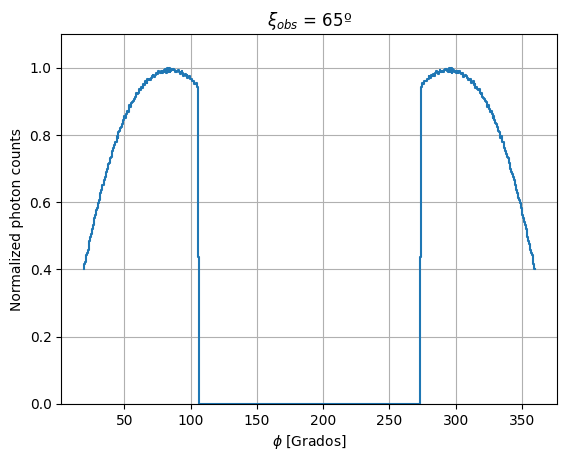

In [121]:
# We plot the light curve
phi_counts = hist3[0]
phi_bins = hist3[1]
binned_phi = []
pbar = tqdm(range(len(phi_bins) - 1))
for n in pbar:
    binned_phi.append((phi_bins[n] + phi_bins[n + 1]) / 2)
    pbar.set_description(f'Plotting light curve')
a_binned_phi = np.array(binned_phi)
full_binned_phi = np.append(a_binned_phi, a_binned_phi+180)
a_counts = np.array(phi_counts)
full_counts = np.append(a_counts/max(a_counts), a_counts[::-1]/max(a_counts))
      
plt.figure(2)
plt.grid(True)
plt.title(r'$\xi_{obs}$ = 65º')
plt.step(full_binned_phi, full_counts, where='mid')
plt.xlabel(r'$\phi$ [Grados]')
plt.ylabel('Normalized photon counts')
plt.ylim([0,1.1])
plt.show()